# Lasso

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), it performs a regression trying to minimize the sum of squared error by estimating **sparse coefficients**. Therefore, it tries to minimize the following quantity
$$ \frac{1}{2 * n_{samples}} ||y - Xw||^2_2 + \alpha  ||w||_1 , $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of **sparsity** (this regularization is called $L_1$ as it uses the $L_1$ norm of the coefficient vector). 

(*given a vector $x$ with 2 components, the $L_1$ norm is given by $|x_1| + |x_2|$*)

It is a very useful regularization in the case only a few coefficients are important for the final prediction. In fact, by using the $L_1$ norm of the coefficient vector, it tends to set the unimportant coefficients to 0. It is then a useful algorithm also for **automatic feature selection**.

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model, grid_results

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/01_linear_models.csv'  # for storing results
modelname='Lasso'
kfolds = KFold(10, shuffle=True, random_state=541)

In [2]:
Lasso()

Lasso()

# Hyperparameters and their role

* **alpha**: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression, but it is not advised for numerical reasons.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that controls the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **positive**: when True, it forces the coefficients to be positive.
* **precompute**: Whether to use a precomputed Gram matrix to speed up calculations. 'auto' is an option
* **random_state**: relevant only if the selection is random.
* **selection**: if set to 'random', a random coefficient is updated every iteration rather than looping over features sequentially. It can speed up the convergence.
* **tol**: the precision of the solution
* **warm_start**: if True, it reuses the previously fitted model to initialize again. This can be useful in a grid search, where you can reuse aspects of the model learnt from the previous parameter value and thus save time.


Once again, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, selection, positivity of the coefficients, and precomputation of the Gram matrix.

In [3]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.1, 5, 0.05)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False], 
              'lasso__precompute': [True, False]}

res = grid_results(model, kfolds, param_grid, data_name='data/simulated/100_feat_65_inf_nonoise.csv', sample=500)

res.head()

{'lasso__alpha': 0.1, 'lasso__positive': True, 'lasso__precompute': False, 'lasso__selection': 'random', 'lasso__tol': 0.0002}


param_lasso__alpha param_lasso__positive param_lasso__precompute  \
0                0.1                  True                   False   
1                0.1                  True                    True   
2                0.1                  True                   False   
3                0.1                  True                    True   
4                0.1                  True                   False   

  param_lasso__selection param_lasso__tol  mean_train_score  std_train_score  \
0                 random           0.0002         -0.722597         0.011617   
1                 random           0.0002         -0.722597         0.011617   
2                 random           0.0001         -0.722415         0.011462   
3                 random           0.0001         -0.722415         0.011462   
4                 random           0.0003         -0.722753         0.011537   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0        -0.838195        0.114956       0.007692      0.000308   
1        -0.838195        0.114956       0.007879      0.001017   
2        -0.838254        0.115555       0.007874      0.000240   
3        -0.838254        0.115555       0.007382      0.000127   
4        -0.838561        0.115059       0.007535      0.000071   

   mean_score_time  std_score_time  
0         0.003594        0.000050  
1         0.003790        0.000350  
2         0.003901        0.000232  
3         0.003864        0.000777  
4         0.003611        0.000056

Let's start with two hyperparameters that should not affect the performance of the model but rather the run time. We see the how faster the model is when the `selection=='random'` and when the Gram matrix is precomputed.

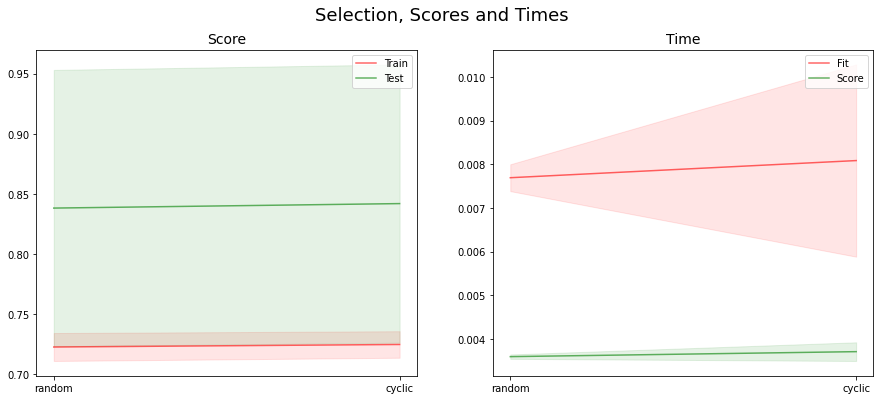

In [4]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0002) & 
                            (res.param_lasso__positive==True) & 
                            (res.param_lasso__precompute==False)], 'param_lasso__selection', 'Selection')

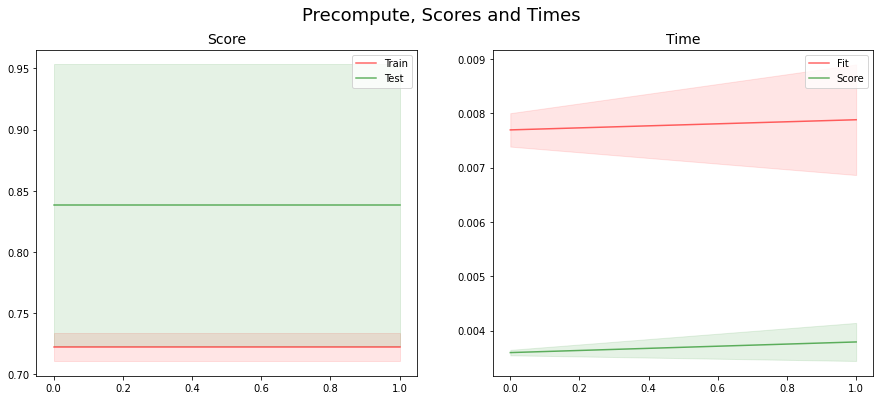

In [5]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0002) & 
                            (res.param_lasso__positive==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__precompute', 'Precompute')

On the other hand, the hyperparameter `positive`, while being very important in terms of model interpretability, is not playing a role in terms of performance or speed, although the fluctuations in training time are much higher when it is set to True

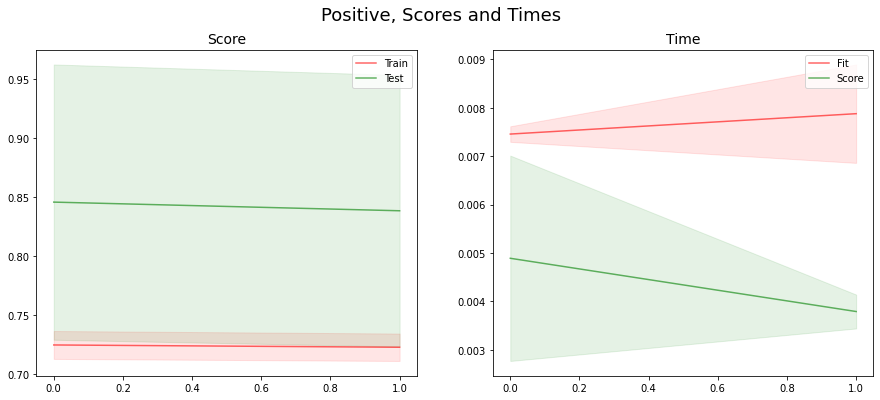

In [6]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0002) & 
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__positive', 'Positive')

The most important hyperparameter is `alpha`, the regularizing term. As we have seen in the previous notebook, **more regularization leads to learning the training data less and less**. In the case of Lasso regularization, this means setting to 0 more and more coefficients and, on this set of data, this means having a model that has a worse and worse performance the more we regularize.

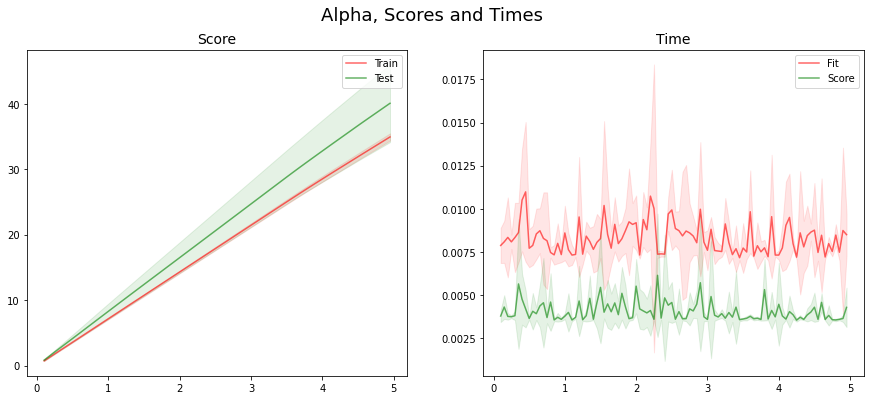

In [7]:
hyp.plot_hyperparameter(res[(res.param_lasso__positive == True) & 
                            (res.param_lasso__tol==0.0002) & 
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__alpha', 'Alpha')

The last parameter is the tolerance and we can see in this joint plot that its importance is very limited, compared to the role of `alpha`.

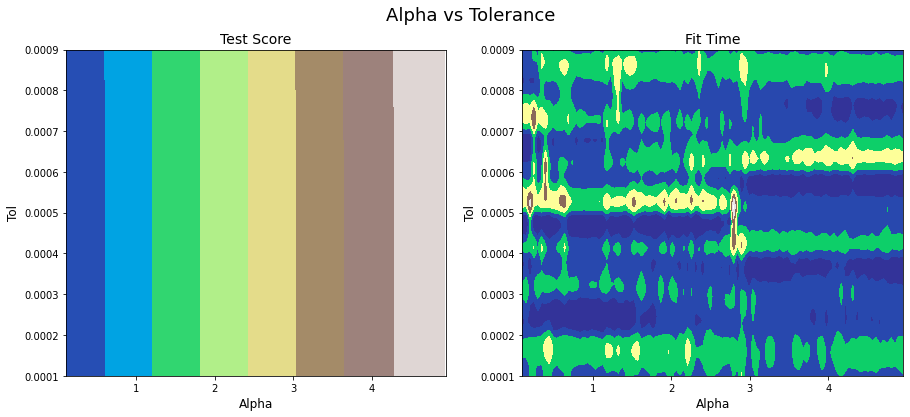

In [8]:
hyp.plot_two_hyperparms(res[(res.param_lasso__positive == True) &
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

In order to not move to the next section with a partial view of the hyperparameters role, we test the model on a different set of data

In [9]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.1, 5, 0.05)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False], 
              'lasso__precompute': [True, False]}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=1000)

res.head()

{'lasso__alpha': 1.4500000000000006, 'lasso__positive': False, 'lasso__precompute': True, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0009000000000000001}


param_lasso__alpha param_lasso__positive param_lasso__precompute  \
0               1.45                 False                    True   
1               1.45                 False                   False   
2                1.4                 False                    True   
3                1.4                 False                   False   
4                1.5                 False                    True   

  param_lasso__selection param_lasso__tol  mean_train_score  std_train_score  \
0                 cyclic           0.0009        -12.269698         0.080915   
1                 cyclic           0.0009        -12.269698         0.080915   
2                 cyclic           0.0009        -12.258037         0.081285   
3                 cyclic           0.0009        -12.258037         0.081285   
4                 cyclic           0.0009        -12.281549         0.080597   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0       -12.758100        0.589839       0.009929      0.000837   
1       -12.758100        0.589839       0.010971      0.000614   
2       -12.758557        0.585318       0.010120      0.000873   
3       -12.758557        0.585318       0.011128      0.001159   
4       -12.759079        0.594881       0.009941      0.000624   

   mean_score_time  std_score_time  
0         0.004152        0.000261  
1         0.004144        0.000129  
2         0.004291        0.000616  
3         0.004170        0.000237  
4         0.004340        0.000687

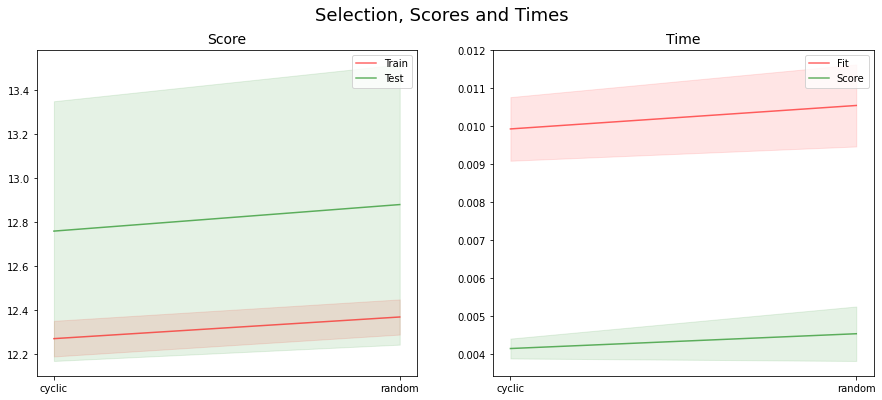

In [10]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 1.4500000000000006) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__precompute==True)], 'param_lasso__selection', 'Selection')

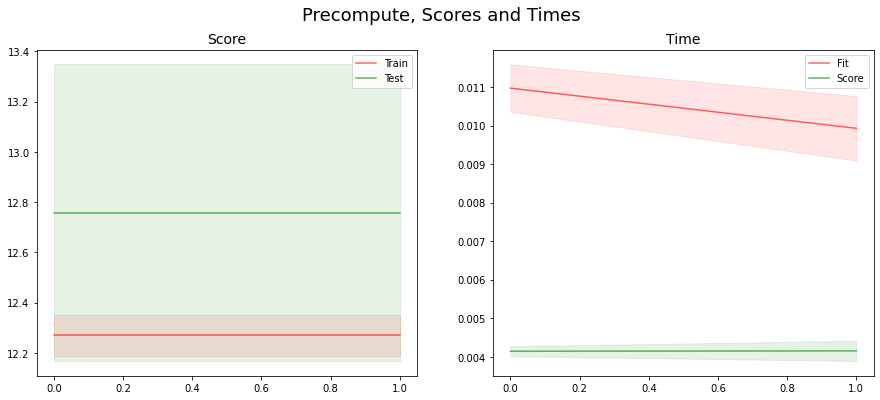

In [11]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 1.4500000000000006) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__precompute', 'Precompute')

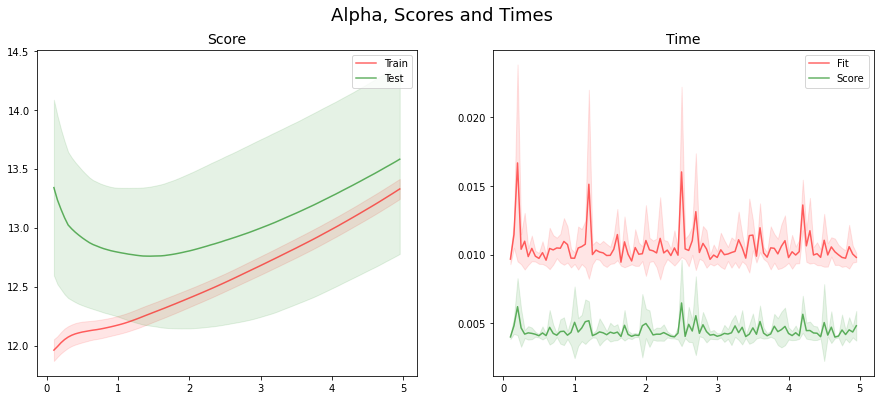

In [12]:
hyp.plot_hyperparameter(res[(res.param_lasso__precompute == True) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__alpha', 'Alpha')

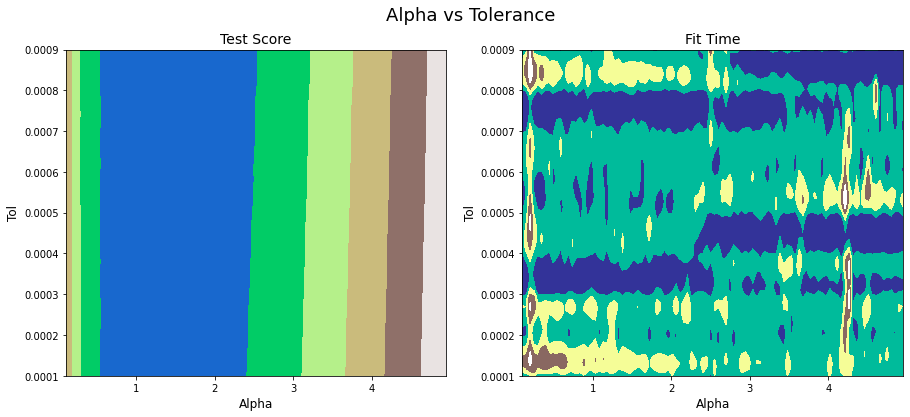

In [13]:
hyp.plot_two_hyperparms(res[(res.param_lasso__precompute == True) &
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

In this case, we see that both `precompute` and `selection` do not play a relevant role in improving the speed of the model. This time, we see that `alpha` can help the model in its predictions. In fact, in this case the target is generated by using only a few features and thus ignoring the useless ones is improving the model. We also see that `tol` can have some influence on the model performance but it is definitely `alpha` the hyperparameter to tune.


# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [14]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

params = {'alpha': 1}

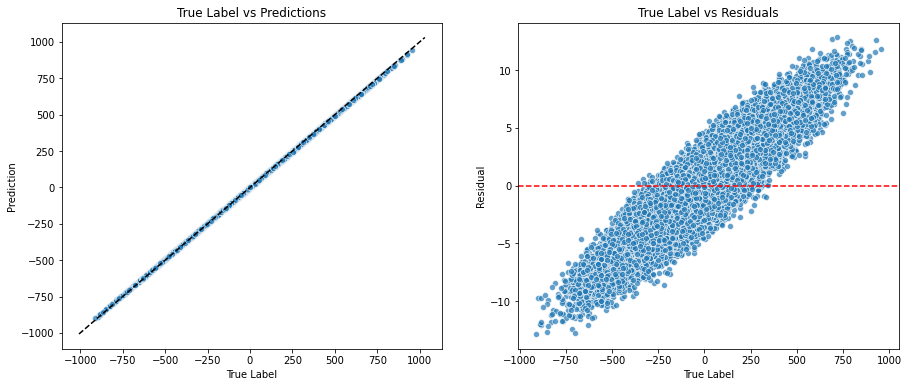

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


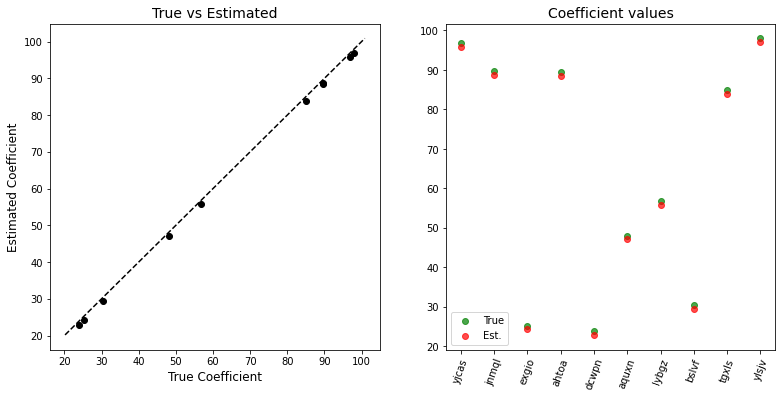

MAE: 		 2.52555
MSE: 		 10.03685
Max Error: 	 12.86134
Expl Variance: 	 0.9998


In [15]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

All the coefficients are underestimated and the performance is worse than before. As in the previous case, the regularization is causing the model to underfit the data and, in contrast with the $L_2$ regularization, this is compromising both performance and coefficients' estimates.

The same can be said when we introduce some noise in the data, although the drop in performance is less visible.

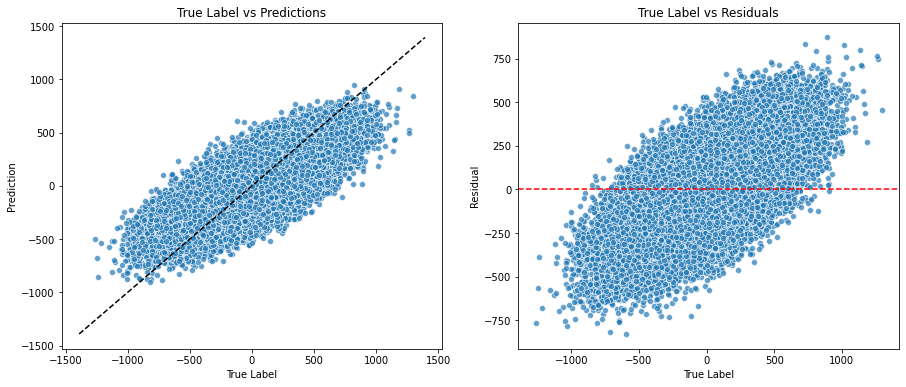

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


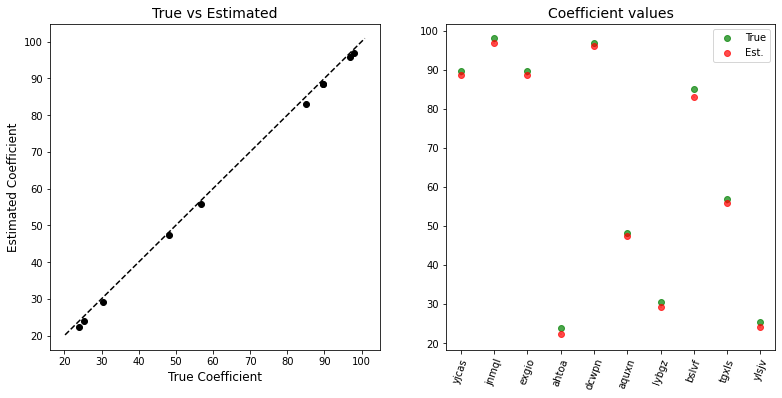

MAE: 		 159.17643
MSE: 		 39913.49636
Max Error: 	 870.55353
Expl Variance: 	 0.55326


In [16]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This kind of regularization is expected to be more useful when we are training with features that have no relation with the target variable, since the model will more likely set their coefficients to 0. This is the case for the next example, where only 65 out of the 100 features are relevant.

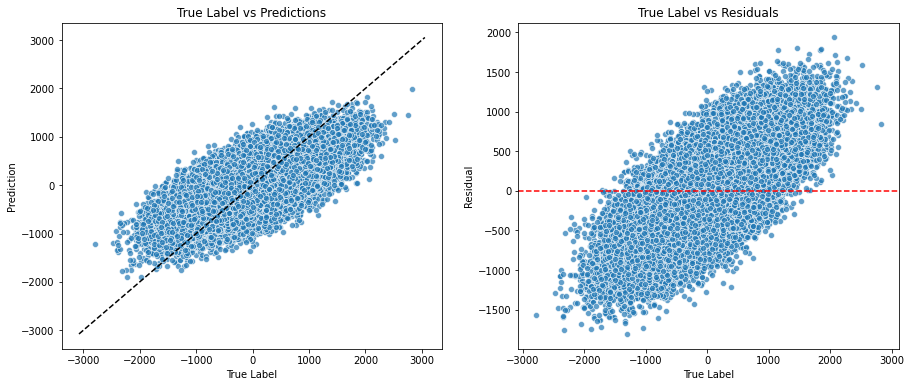

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


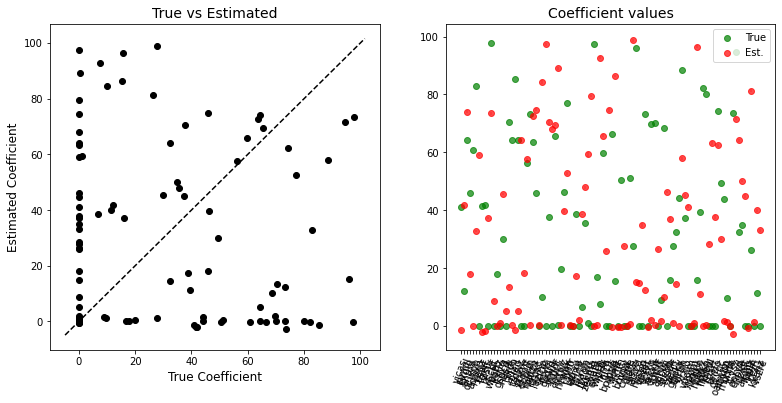

MAE: 		 359.49162
MSE: 		 202607.06105
Max Error: 	 1937.26028
Expl Variance: 	 0.48914


In [17]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.55, random_state=325))])

params = {'alpha': 0.55}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We did not cure entirely the fact that the model sets to 0 many non-zero coefficients but we can at least see a small improvement in performance.

The same cannot be said if we also introduce some correlation between features.

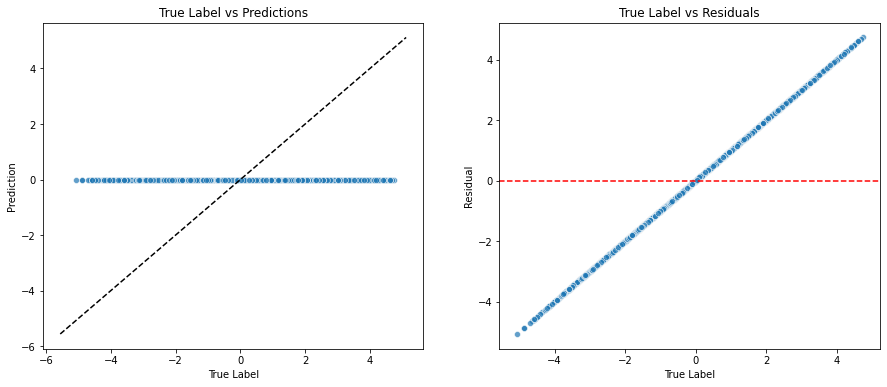

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


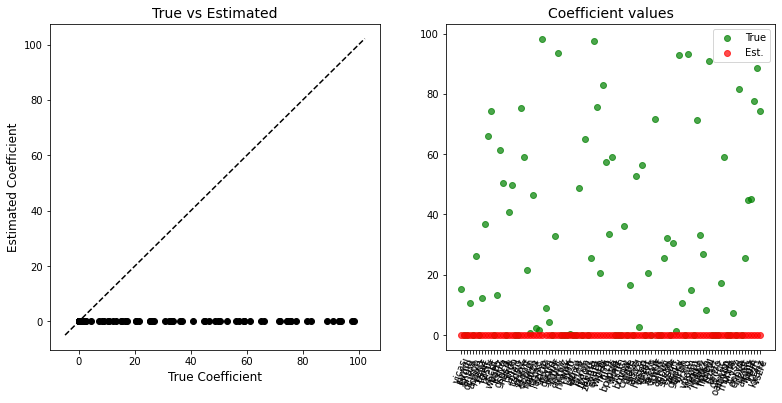

MAE: 		 0.93297
MSE: 		 1.36511
Max Error: 	 5.06419
Expl Variance: 	 -1e-05


In [18]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As the model is predicting nothing but 0's.

# Number of instances

The behavior is not changing much when we introduce the regularization. However, as in the case of `Ridge` the implementation is much more optimized and thus we get a better performance in terms of speed.

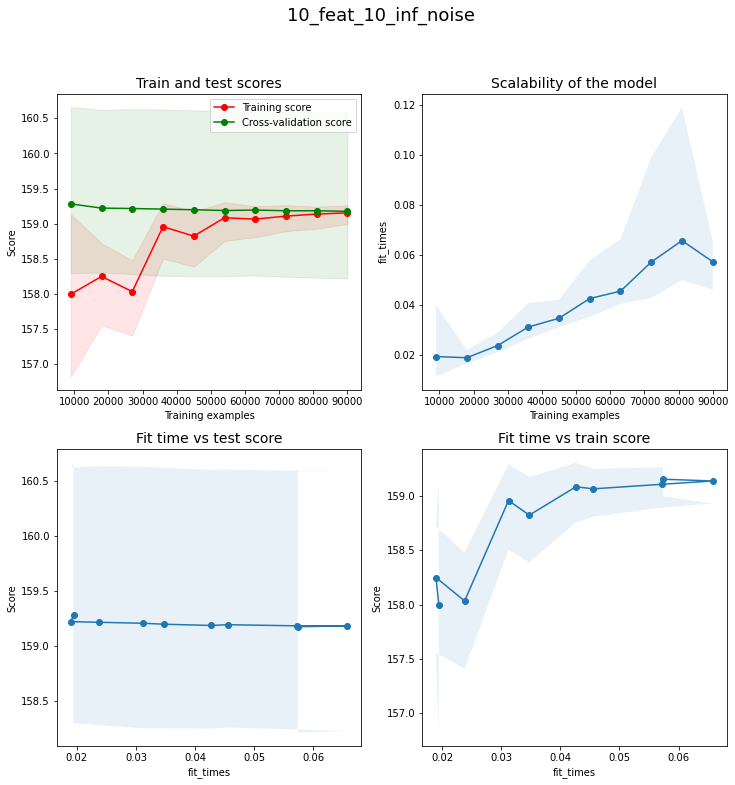

In [19]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds without the regularization, while now it is around 0.55 seconds.

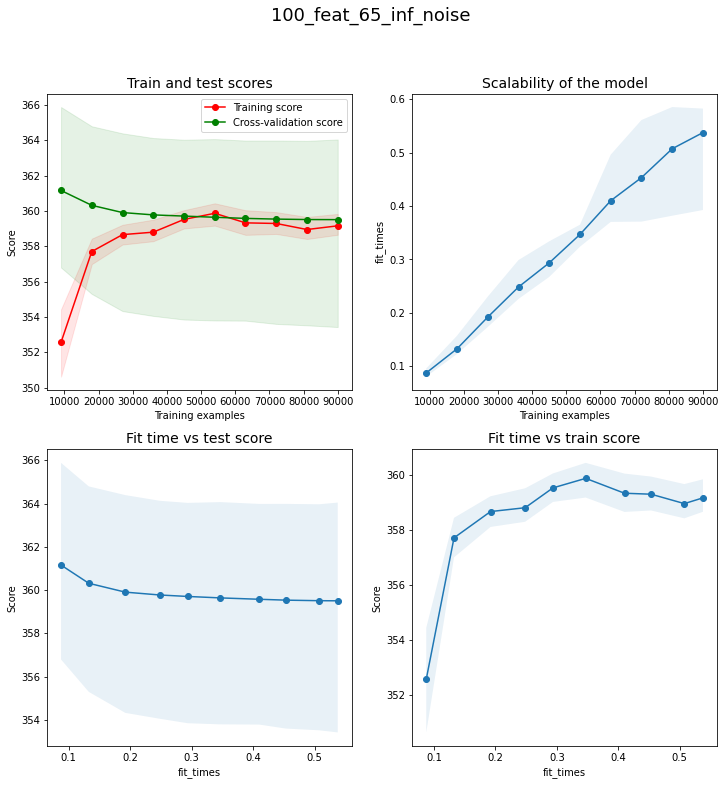

In [20]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

In the previous notebook we said that, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`. For numerical reasons, it is not adviced to do the same with `Lasso(alpha=0)`.

By reducing the number of training instances, we observe a less accurate set of predictions and the same underestimation of the coefficients.

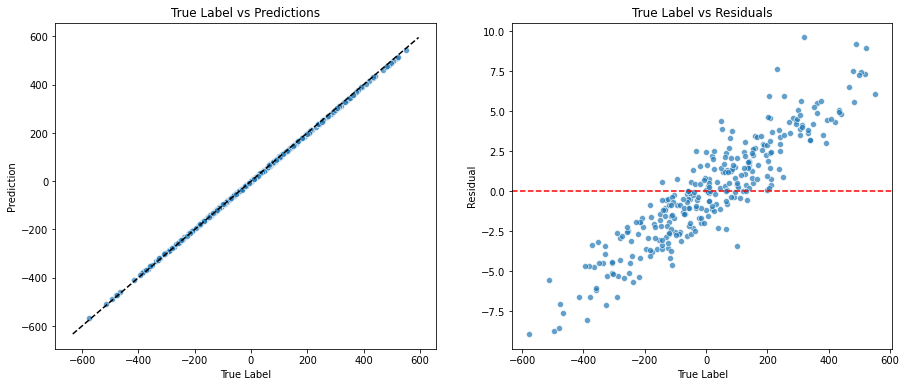

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


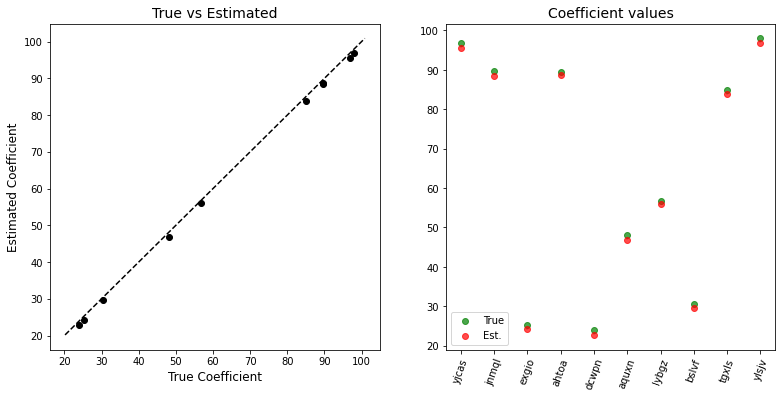

MAE: 		 2.666
MSE: 		 11.35782
Max Error: 	 9.61946
Expl Variance: 	 0.99977


In [21]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

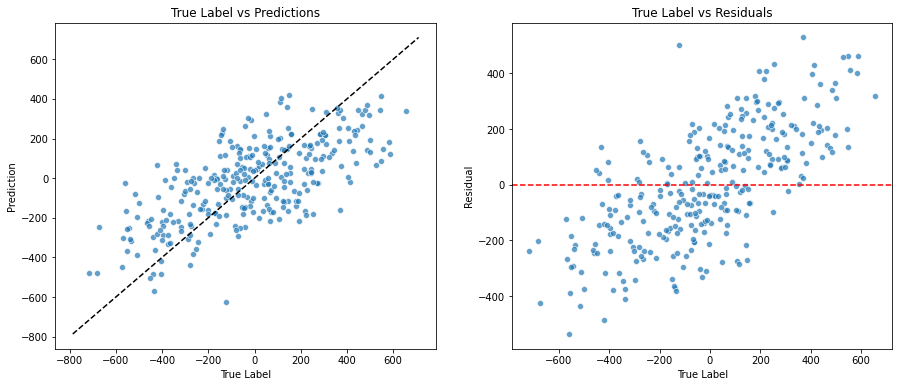

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


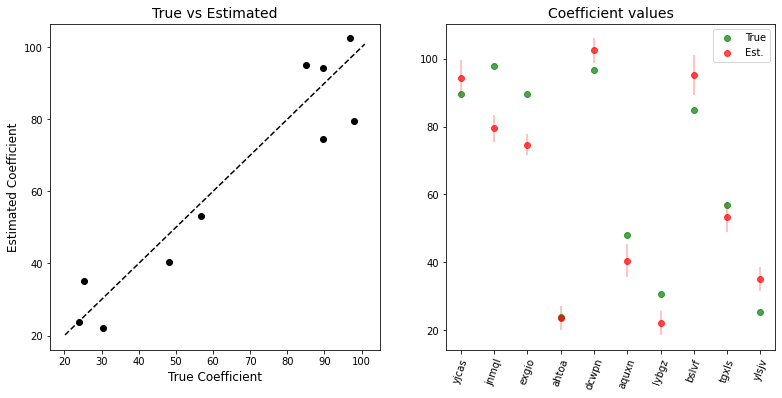

MAE: 		 171.80971
MSE: 		 43183.5947
Max Error: 	 536.48786
Expl Variance: 	 0.46306


In [22]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations.

## 100 features

As in the previous examples, the speed of the model is much higher (thanks to the better implementation) and we can again observe that the regularizing term is not influencing the ability of the model to be close to the best achievable result already with 9000 training samples.

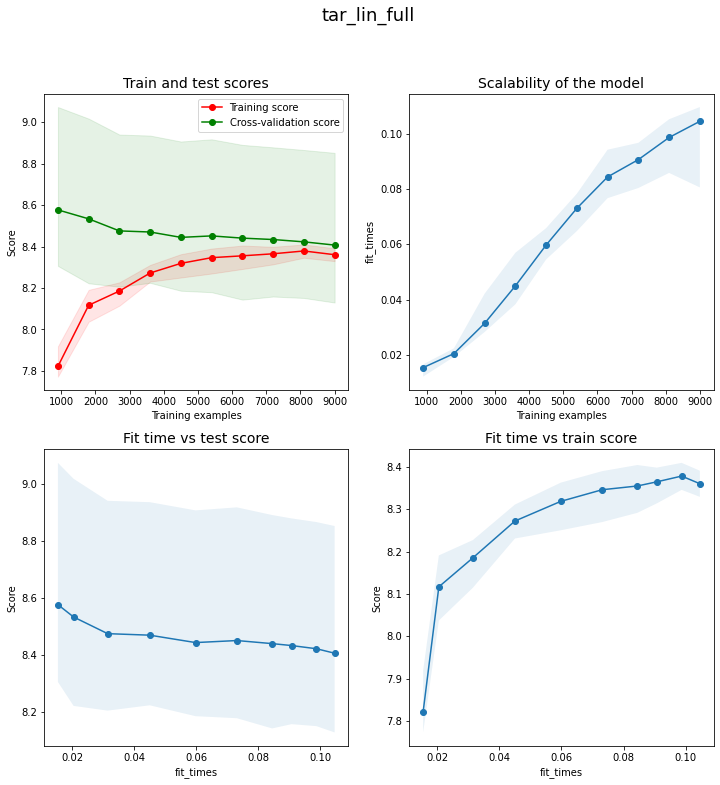

In [23]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

When using all the features, we can see how the model is setting to 0 several coefficients, regardless of their magnitude

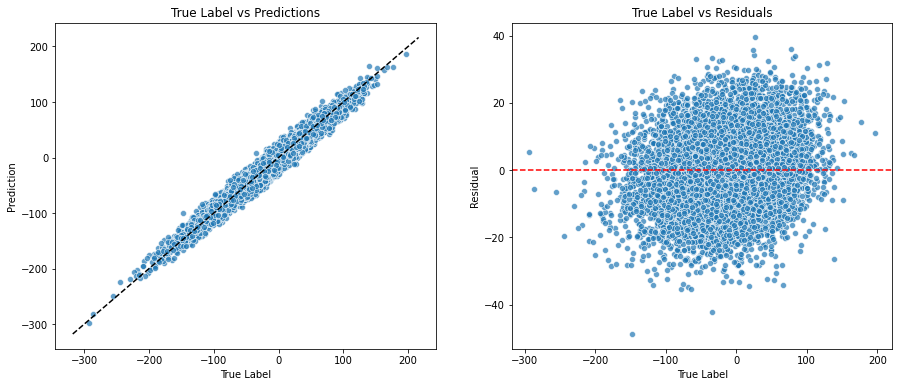

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


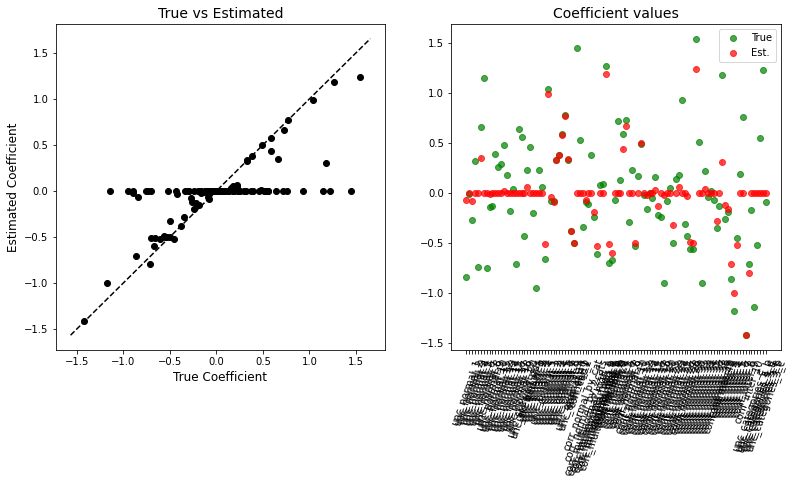

MAE: 		 8.45593
MSE: 		 112.86265
Max Error: 	 48.7079
Expl Variance: 	 0.96547


In [24]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As a consequence, the model is performing worse than before.

On the other hand, when reducing the number of training instances the drop in performance is much smaller than before.

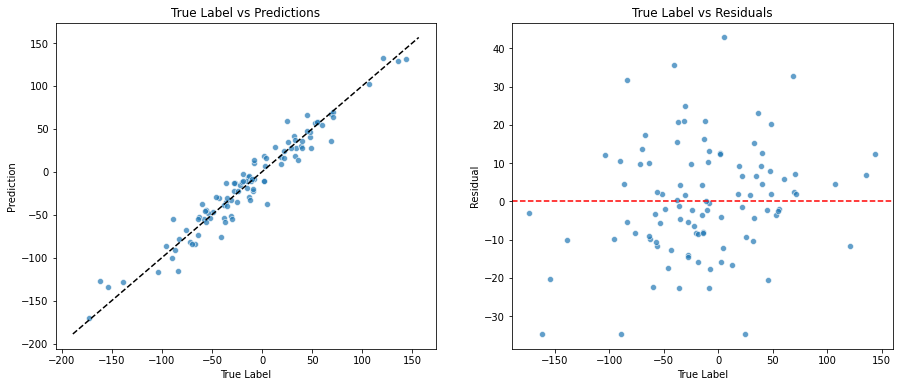

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


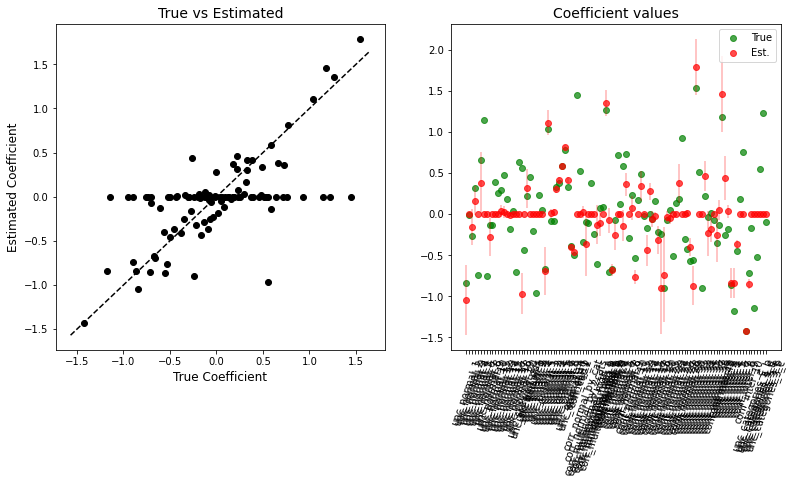

MAE: 		 11.24078
MSE: 		 209.3552
Max Error: 	 42.83429
Expl Variance: 	 0.93922


In [25]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This suggests that **the regularization is somewhat helping** and we indeed see that increasing it leads to a better performing model. This can be seen in the following plot.

{'lasso__alpha': 2.25}


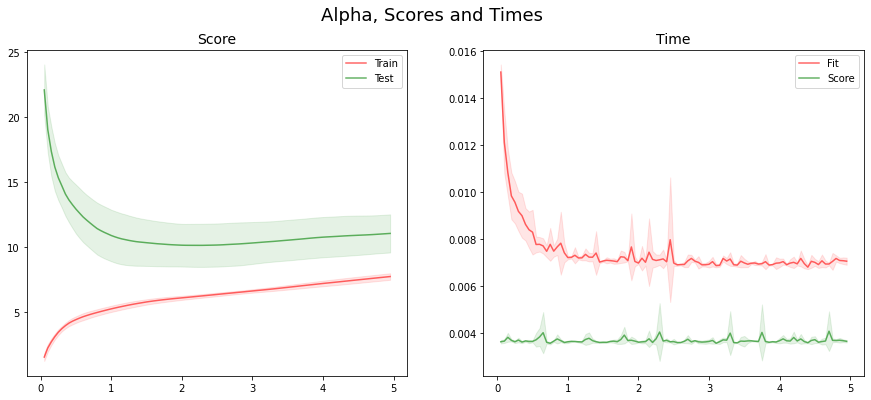

In [26]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', sample=100)

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

And we can indeed see a better perfoming model already with `alpha=2.5`

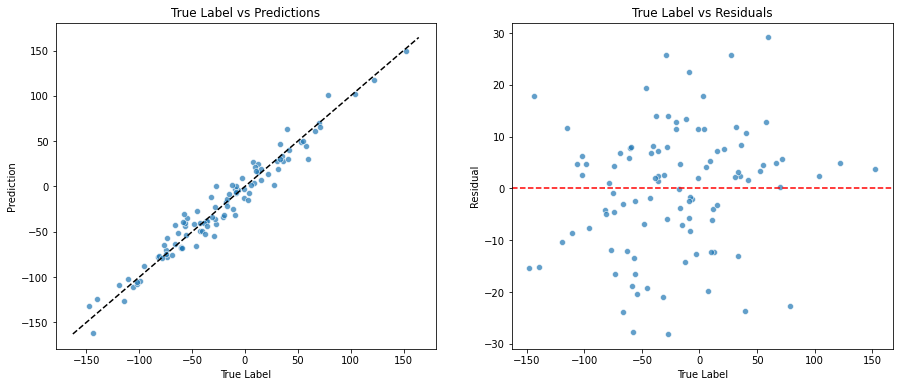

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


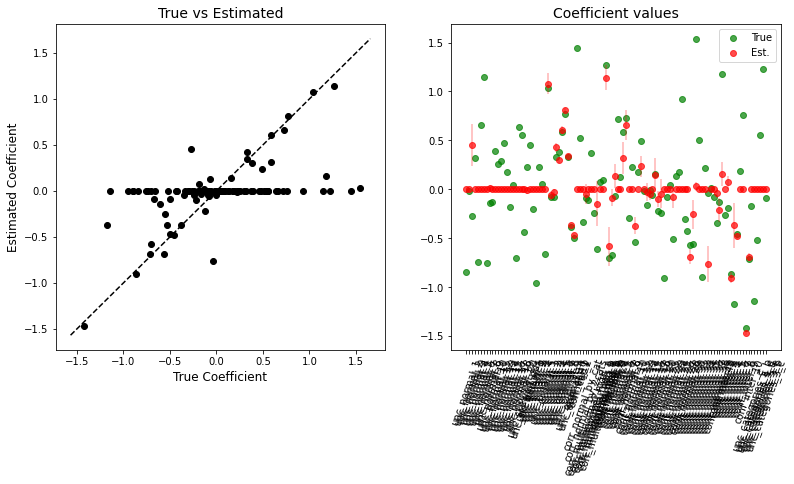

MAE: 		 9.60342
MSE: 		 145.06556
Max Error: 	 29.16053
Expl Variance: 	 0.95535


In [27]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2.5, random_state=325))])
params = {'alpha': 2.5}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Since we are curious about what would happen if all the coefficients were forced to be positive, we can see how bad the model gets in the next experiment.

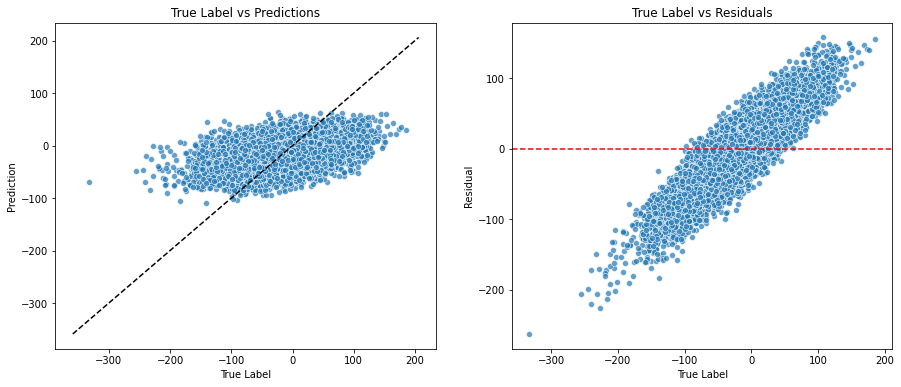

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


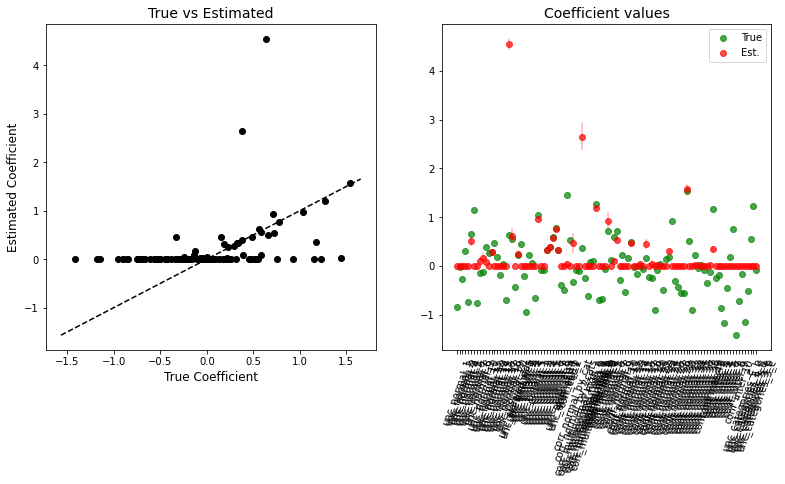

MAE: 		 40.0673
MSE: 		 2595.2032
Max Error: 	 263.17839
Expl Variance: 	 0.21458


In [28]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.5, positive=True, random_state=325))])
params = {'alpha': 0.5, 'positive': 'True'}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

In the presence of **unobserved variables**, however, the model struggles but not significantly more than before.

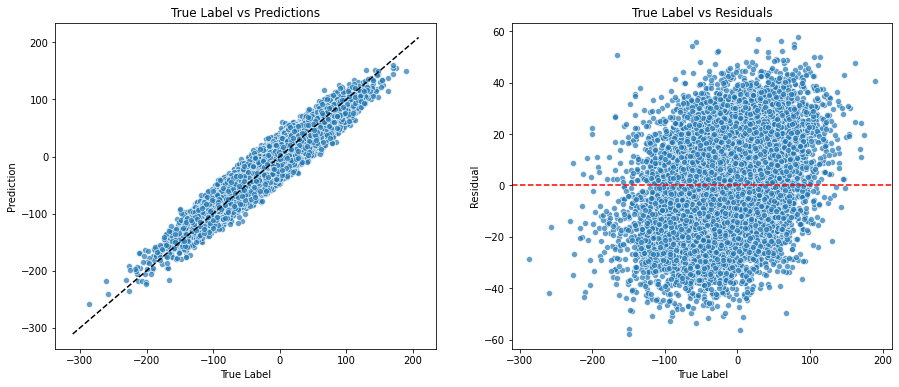

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


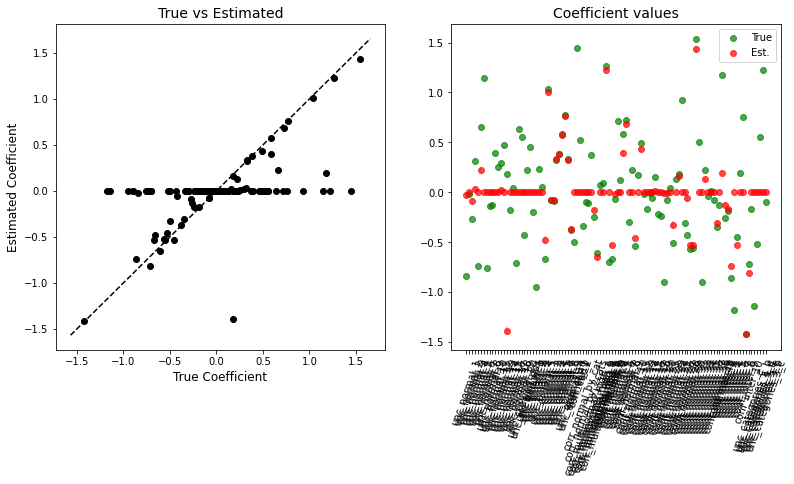

MAE: 		 15.91173
MSE: 		 369.40104
Max Error: 	 57.76844
Expl Variance: 	 0.88823


In [29]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 50 features

Let's now turn our attention to a situation where only 50 features of the 100 available have been used to generate the target

In [30]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

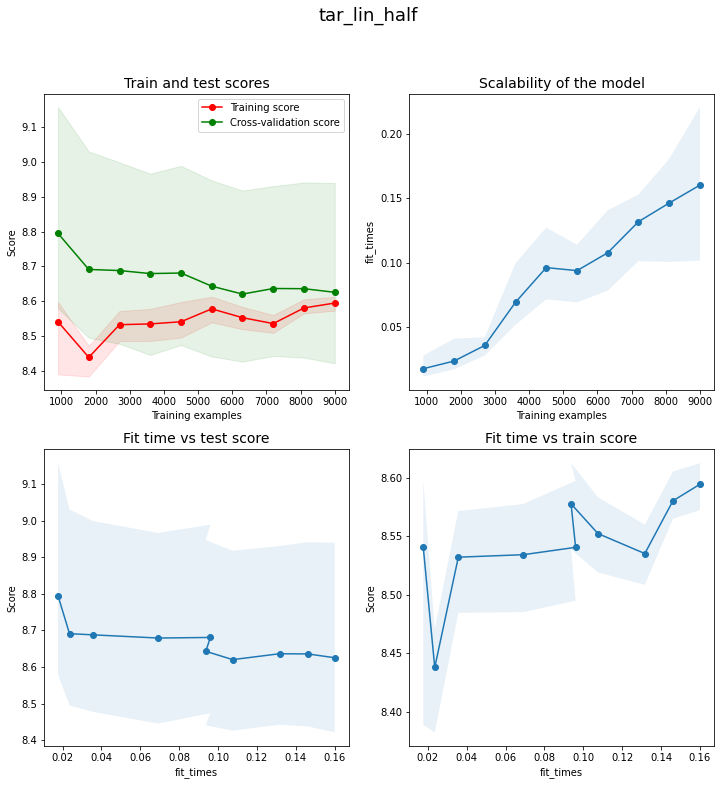

In [31]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

We can again appreciate how faster and more accurate the model becomes when we use the exact features we need to predict the target (remember that it roughly scales with the square of the number of features). Moreover, the model is now showing a more standard learning curve.

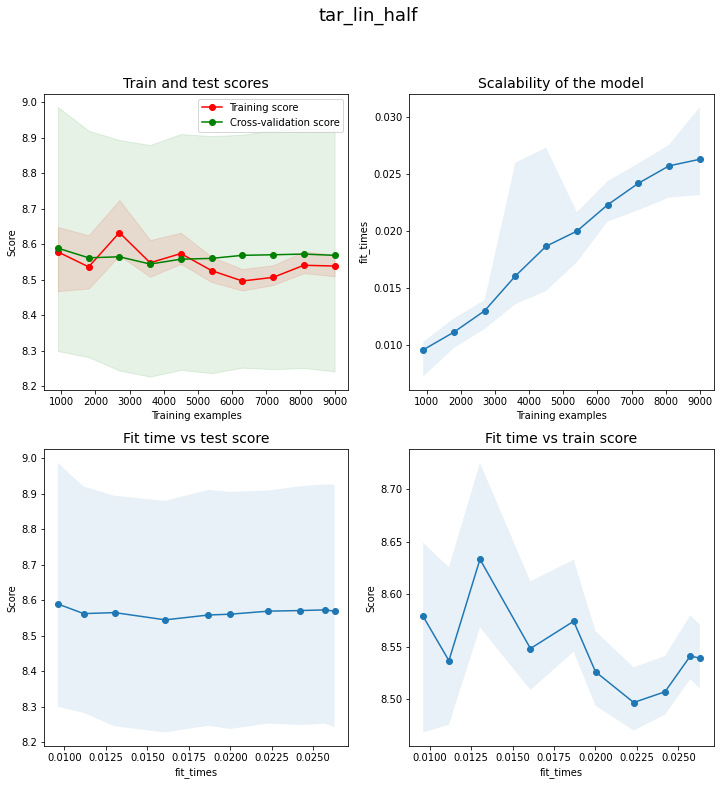

In [32]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We can thus use this as baseline for the next set of experiments. The performance is nearly identical with or without the regularization

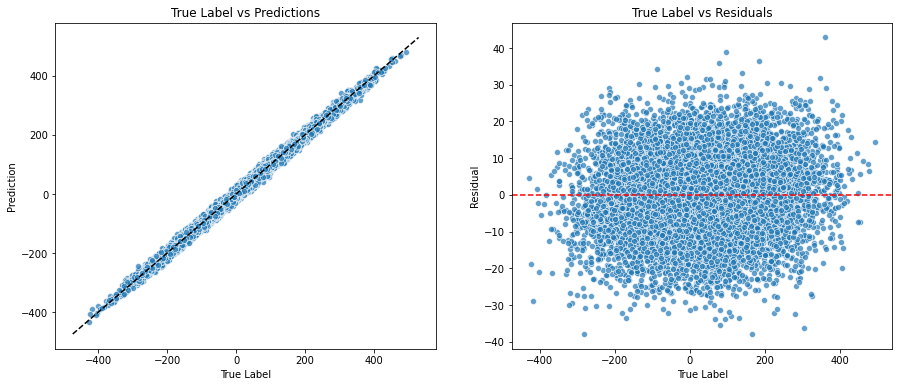

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


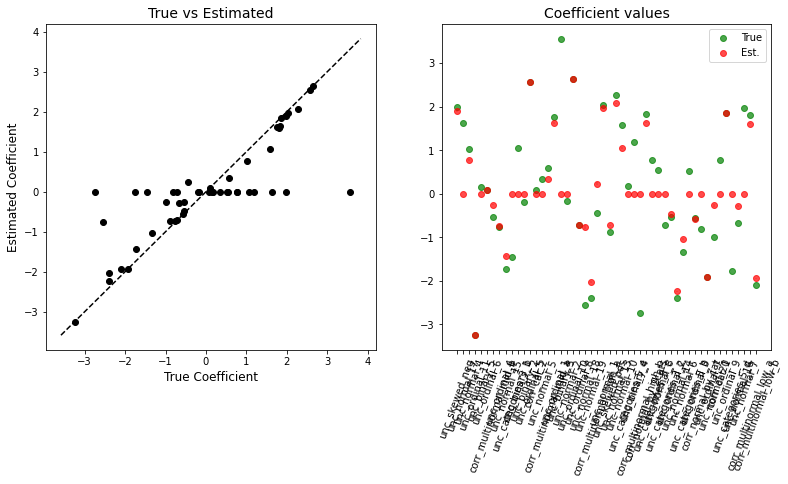

MAE: 		 8.54878
MSE: 		 114.23408
Max Error: 	 42.89048
Expl Variance: 	 0.99476


In [33]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Predictably, reducing the number of training instances leads to a worse performing model but, this time, it is performing better than its non-regularized counterpart

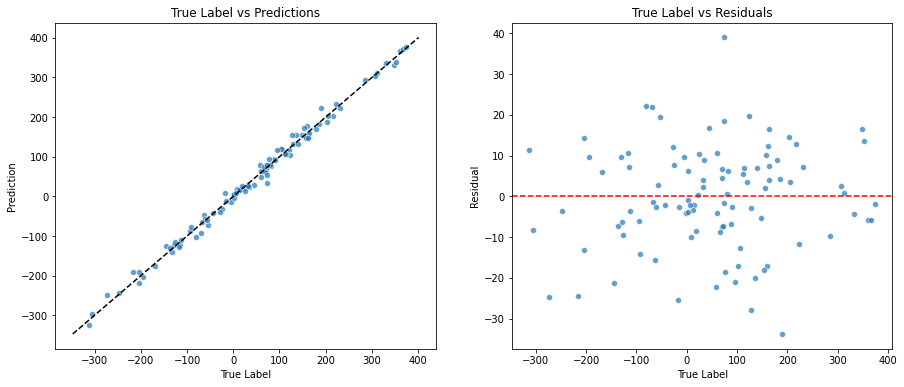

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


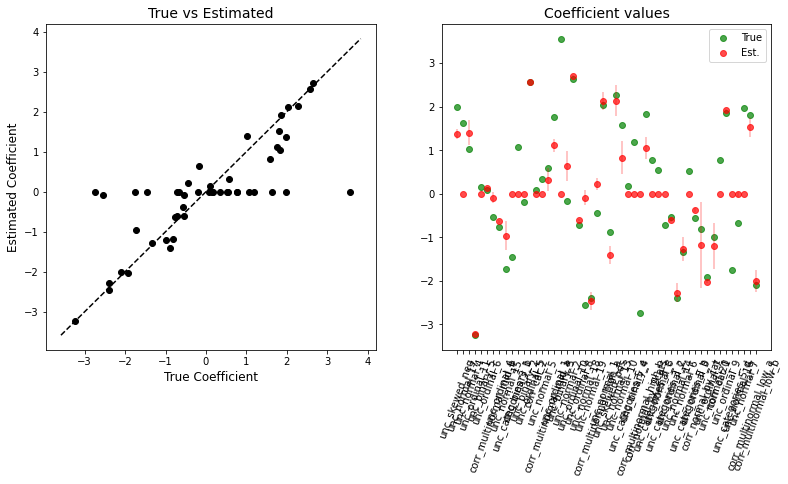

MAE: 		 10.01452
MSE: 		 159.09978
Max Error: 	 39.00413
Expl Variance: 	 0.99311


In [34]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can again search of the best configuration

{'lasso__alpha': 0.8}


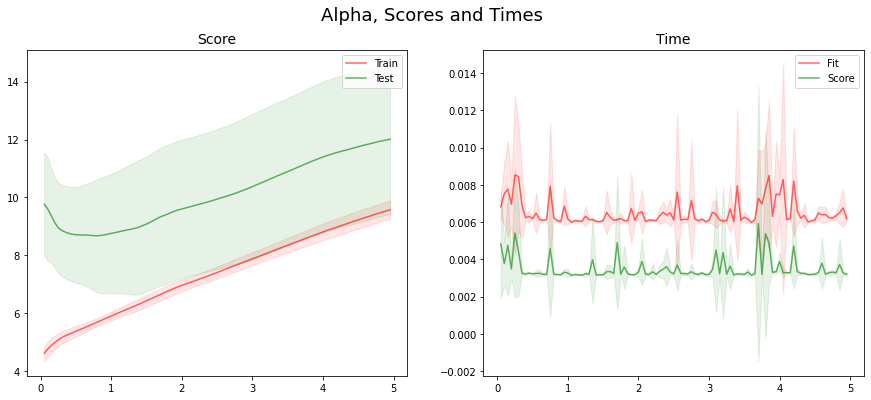

In [35]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100, features='exact')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

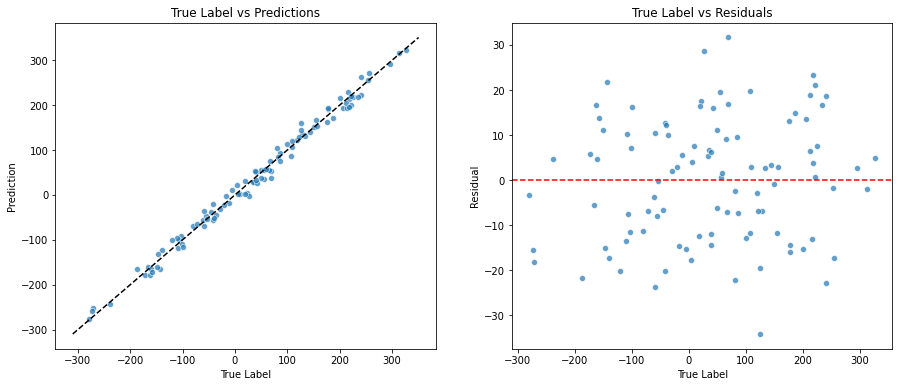

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


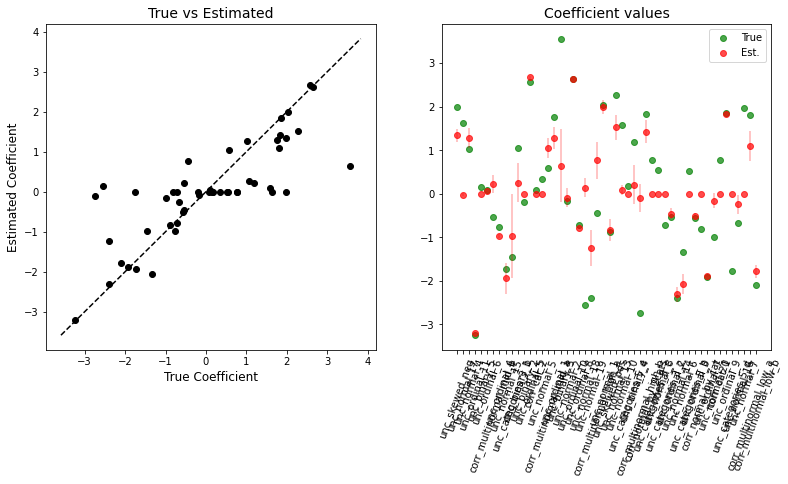

MAE: 		 11.45385
MSE: 		 183.78045
Max Error: 	 34.15165
Expl Variance: 	 0.99078


In [36]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.6, random_state=325))])
params = {'alpha': 0.6}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Once again, **tuning your model for a small improvement can do more harm than good** when the uncertainty is so large.

Training the model on more features than necessary doesn't seem to influence the performance or the coefficients' estimates much (meaning that the estimate is still fairly poor).

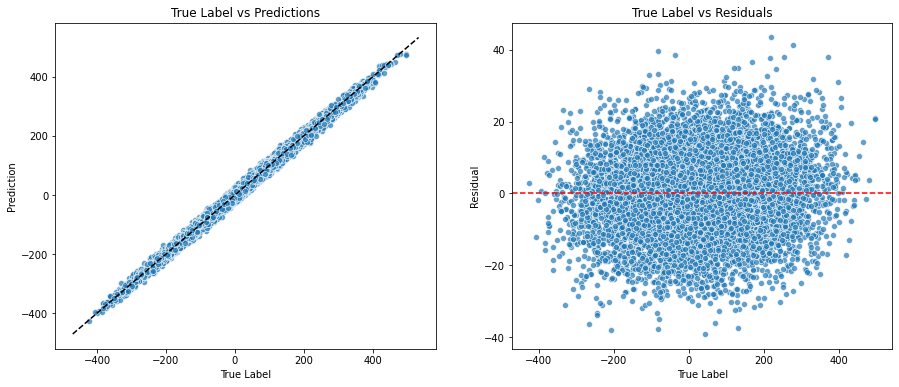

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


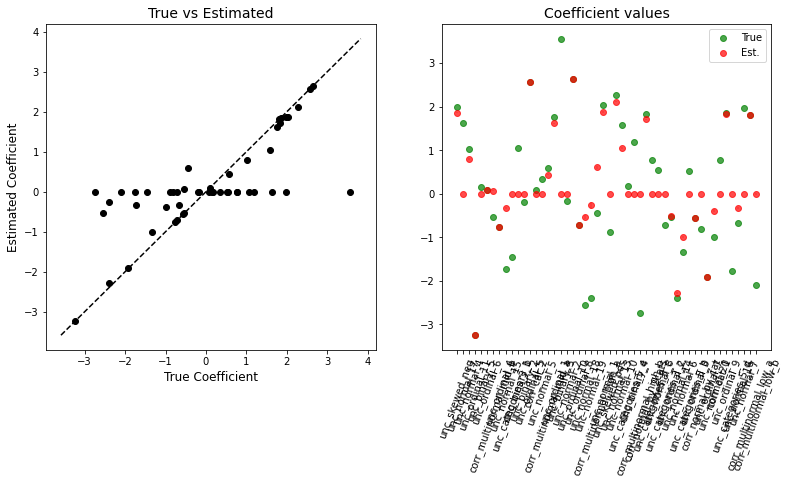

MAE: 		 8.6217
MSE: 		 116.85875
Max Error: 	 43.36131
Expl Variance: 	 0.99474


In [37]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

The role of the optimization can be observed again when we have to work with a limited amount of observations. Indeed, the regularization will set to 0 coefficients that are not relevant and thus control the overfitting of the model on this limited dataset.

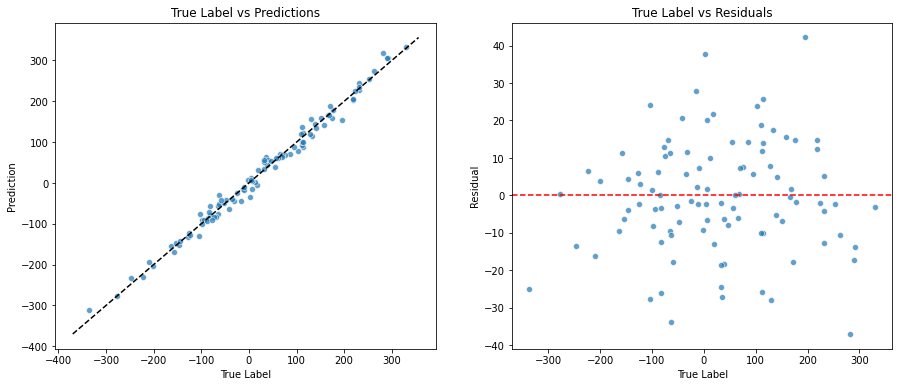

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


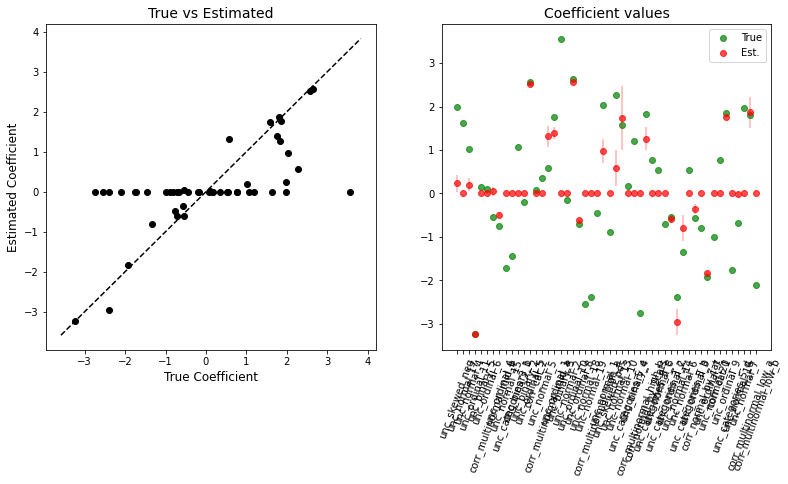

MAE: 		 11.59703
MSE: 		 220.97825
Max Error: 	 42.14935
Expl Variance: 	 0.98832


In [38]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

{'lasso__alpha': 1.9000000000000001}


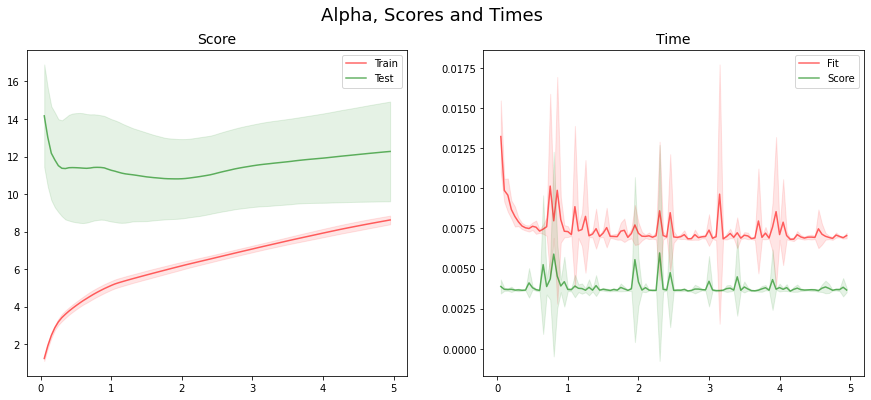

In [39]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

We see indeed how a model with regularization is outperforming its unregularized counterpart.

On the other hand, when it is a certain number of features missing, the regularization does not seem to help much.

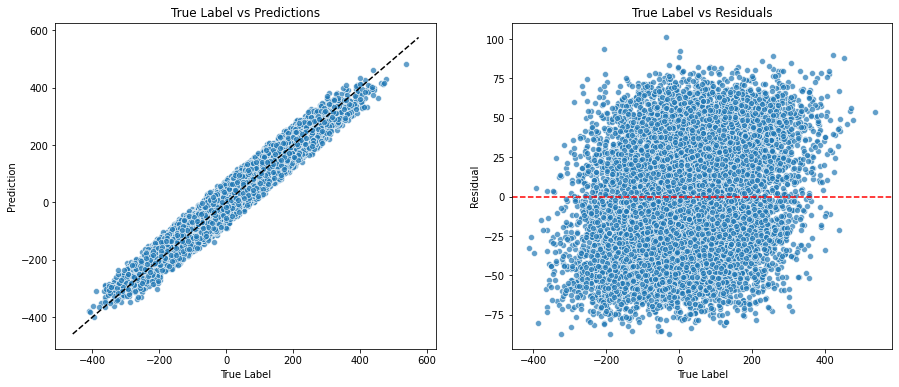

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


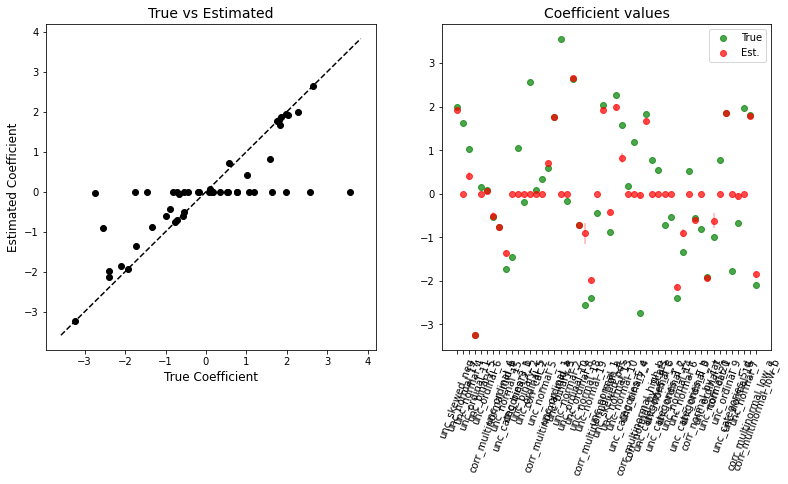

MAE: 		 32.55132
MSE: 		 1449.50823
Max Error: 	 101.01073
Expl Variance: 	 0.93272


In [40]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

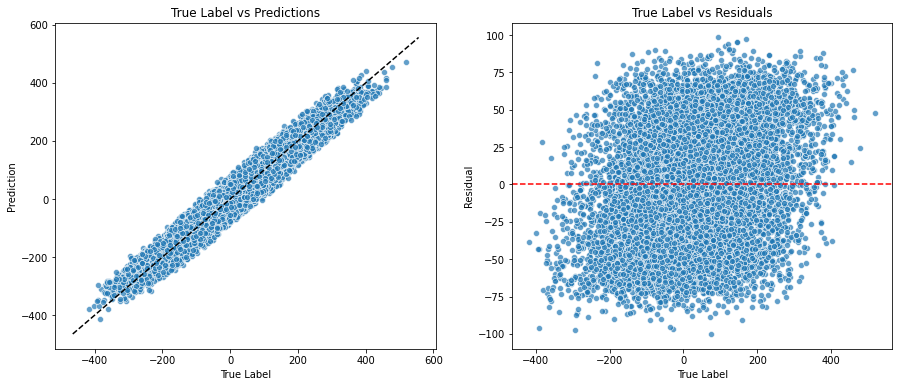

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


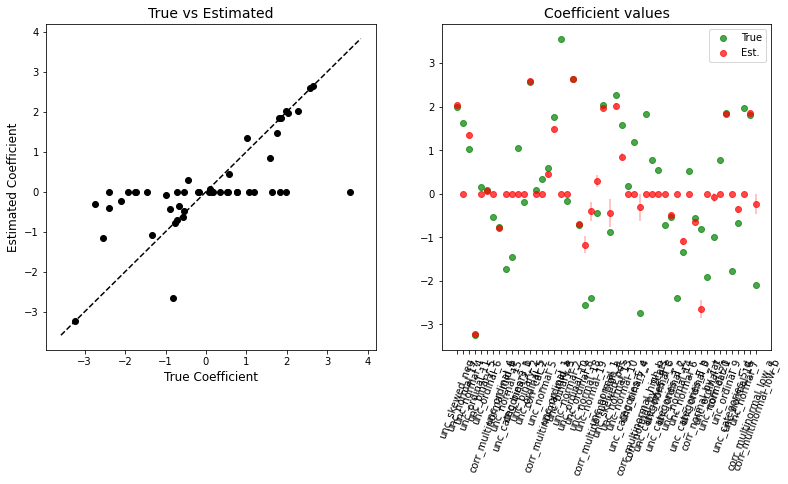

MAE: 		 34.26605
MSE: 		 1611.49284
Max Error: 	 100.05511
Expl Variance: 	 0.92484


In [41]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 10 features

With a low number of features, the Lasso regularization tends to put too many coefficients to 0, resulting in a model that performs worse than its unregularized counterpart (and of the $L_2$ regularized version)

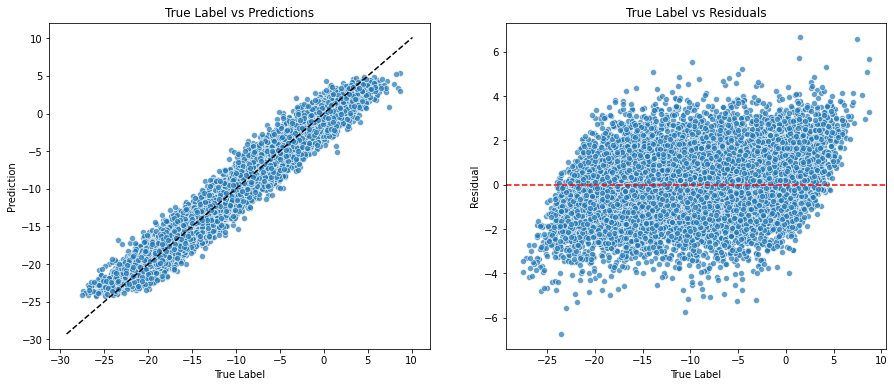

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


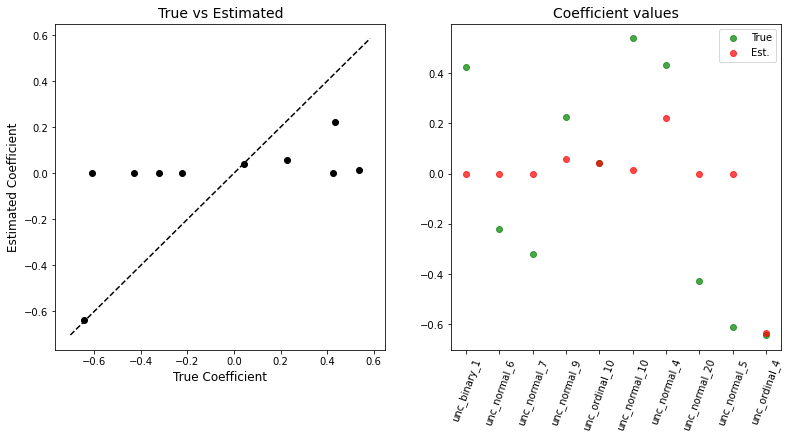

MAE: 		 1.24437
MSE: 		 2.43955
Max Error: 	 6.73673
Expl Variance: 	 0.95724


In [42]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We even get a better performance by reducing the number of observations, a result that challenge our intuition quite considerably.

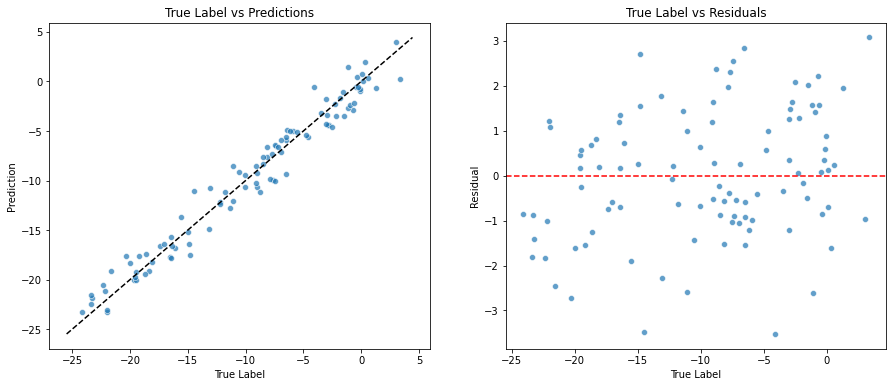

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


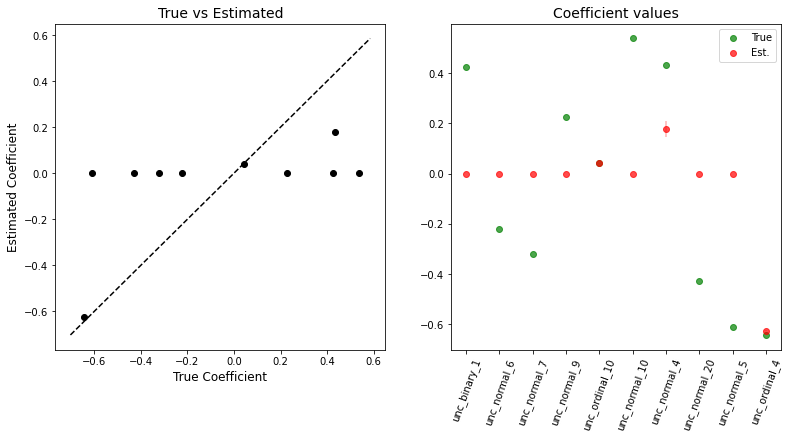

MAE: 		 1.1782
MSE: 		 2.04598
Max Error: 	 3.52218
Expl Variance: 	 0.96334


In [43]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This poor perfomance seems to be unaffected by the presence of truly useless variables.

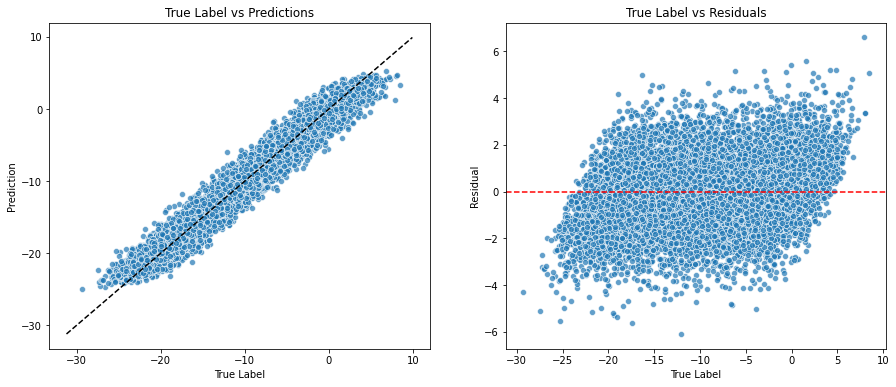

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


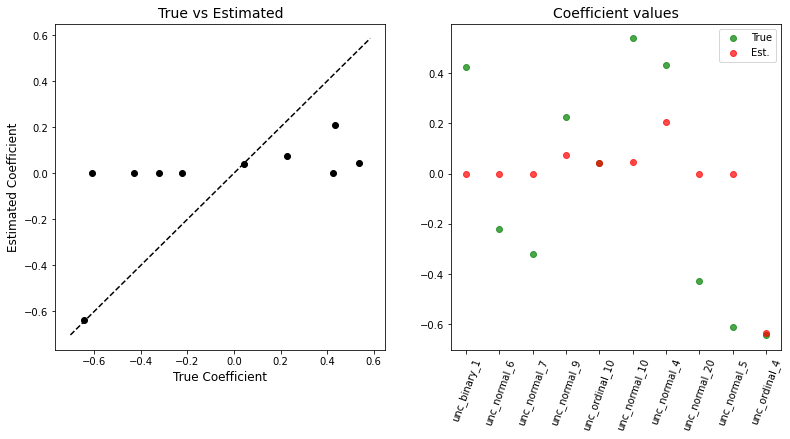

MAE: 		 1.24304
MSE: 		 2.41969
Max Error: 	 6.5935
Expl Variance: 	 0.95776


In [44]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

But for sure it is noticeable when some important feature is missing.

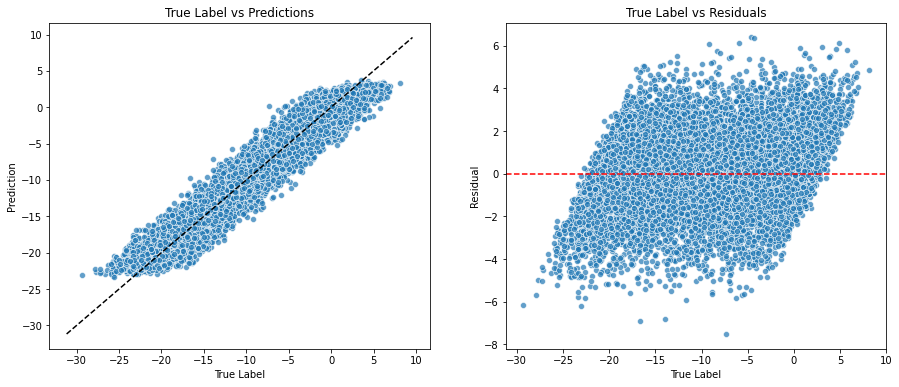

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


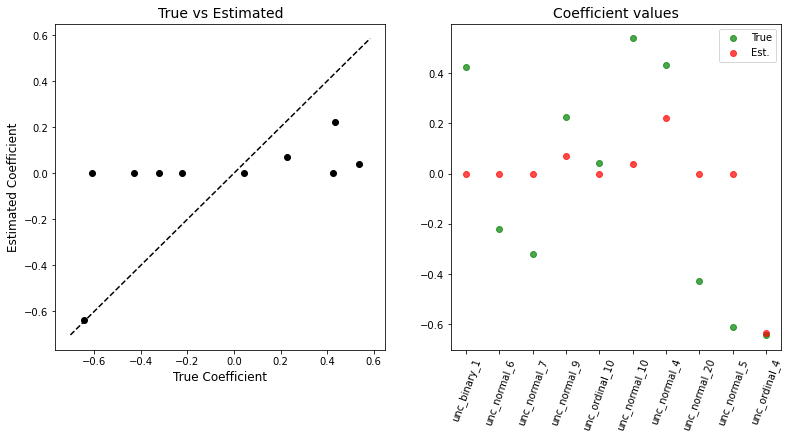

MAE: 		 1.59487
MSE: 		 3.90359
Max Error: 	 7.51831
Expl Variance: 	 0.93218


In [45]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

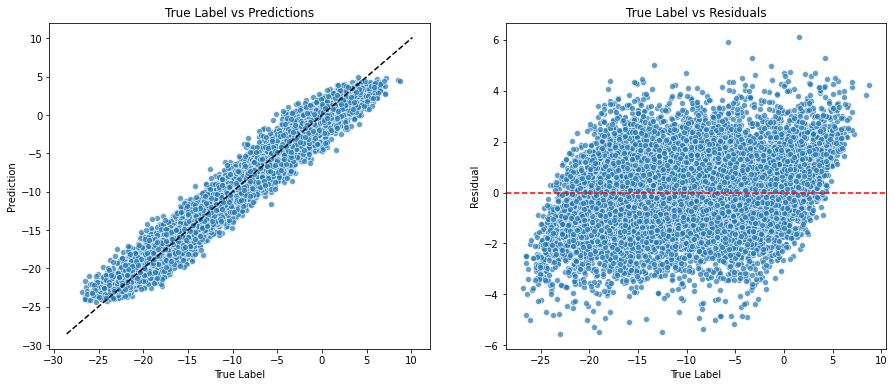

/home/lucabasa/Git/ML-algorithms-and-experiments/source/hyperplots.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(comparison.feat, rotation=70)


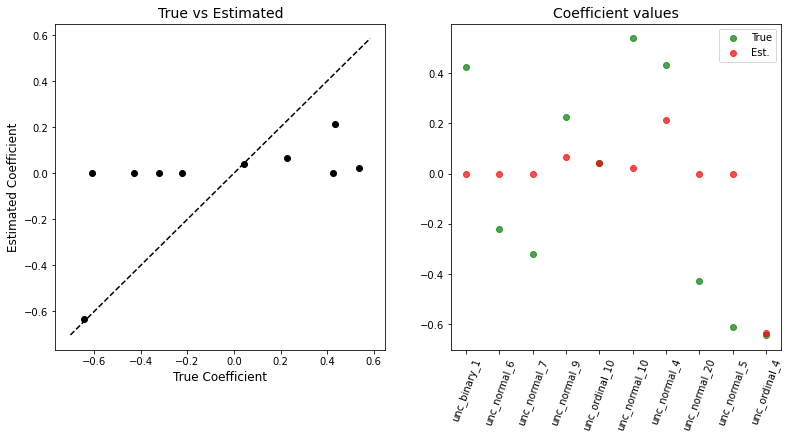

MAE: 		 1.24817
MSE: 		 2.43446
Max Error: 	 6.08977
Expl Variance: 	 0.95752


In [46]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## Non-linear relations

We have seen in notebook 4 that the regularization was helping the (already) surprisingly well-performing model even with a target generated by a non-linear relation.

In this case, we observe that the model needs fewer observation to reach its best performance.

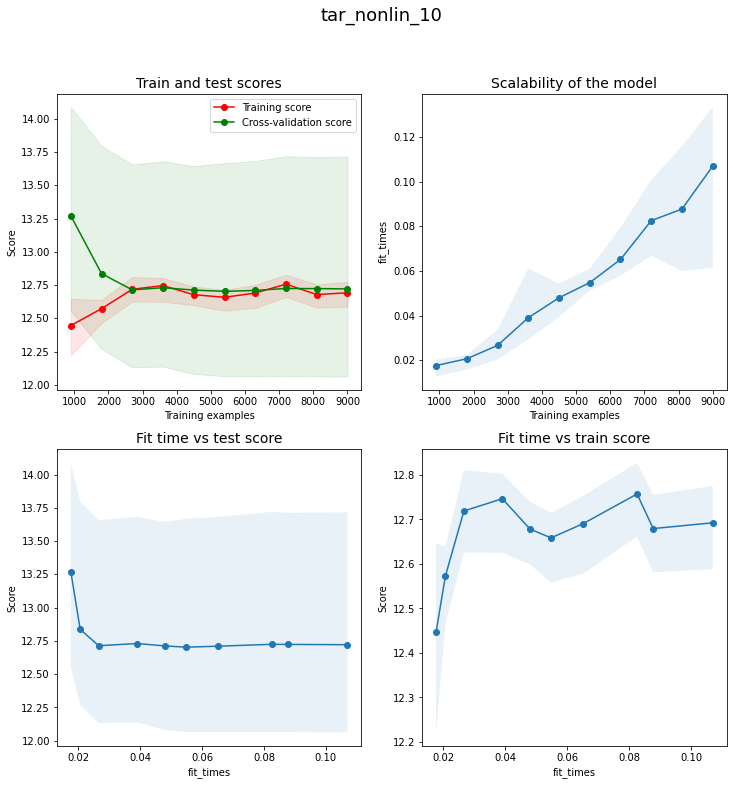

In [47]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

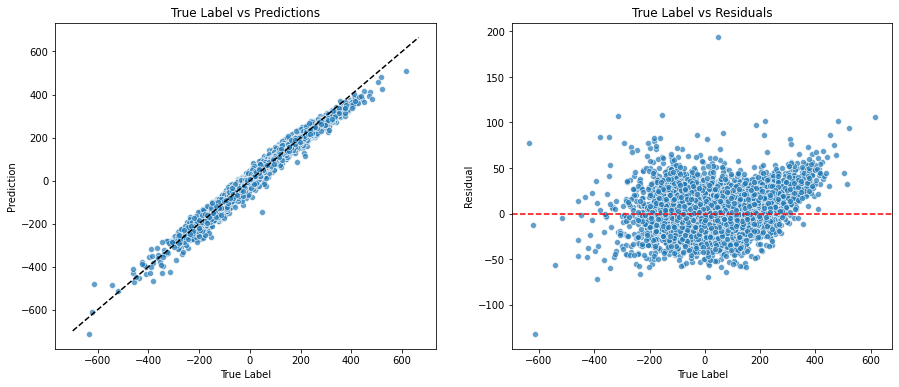

MAE: 		 12.74184
MSE: 		 302.98934
Max Error: 	 193.40387
Expl Variance: 	 0.97918


In [48]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

Once again, reducing the number of observations leads to a worse performance but, once again, it is this the situation where the regularization is helpful the most

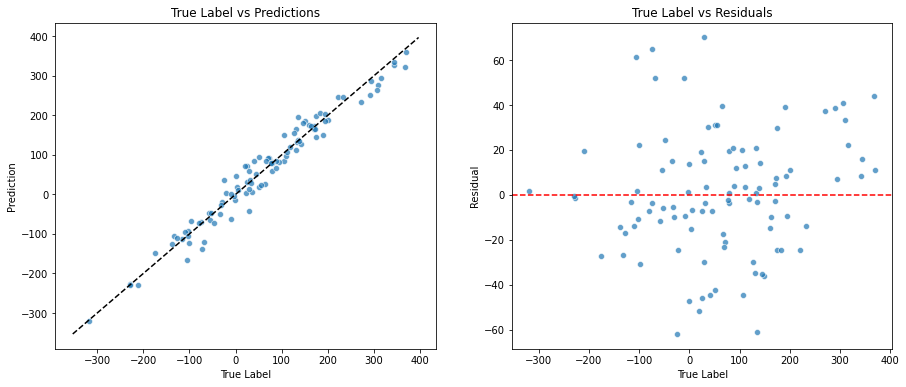

MAE: 		 20.96884
MSE: 		 729.97213
Max Error: 	 70.04419
Expl Variance: 	 0.96232


In [49]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

{'lasso__alpha': 4.4}


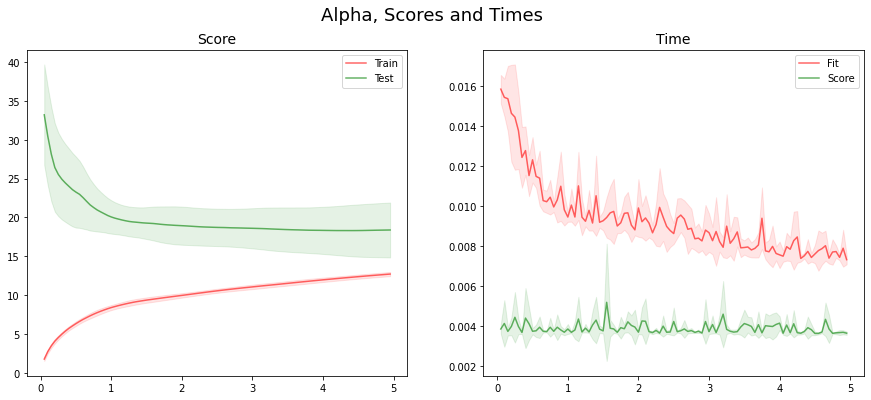

In [50]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

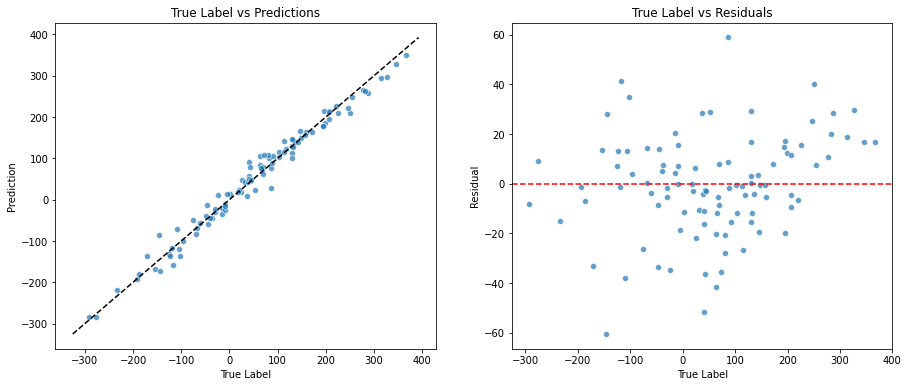

MAE: 		 15.39007
MSE: 		 410.91126
Max Error: 	 60.5225
Expl Variance: 	 0.97857


In [51]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2.5, random_state=325))])
params = {'alpha': 2.1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

# Real application - HousePrice

It is finally time to test the performance of this algorithm on the dataset of the House Price competition. As before, we use a generic pipeline [developed in this notebook](https://www.kaggle.com/lucabasa/houseprice-end-to-end-project). 

We expect to see more and more coefficients to be set to 0 as they refer to truly unimportant features.

First, let's see how the model is influenced by the choice of hyperparameters

In [52]:
model = ('lasso', Lasso())
params = {'alpha':1}

param_grid = {'lasso__alpha': list(np.arange(0.0001, 0.002, 0.0005)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False]}

res = grid_results(model, kfolds, param_grid, hp=True)

res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'lasso__alpha': 0.0006000000000000001, 'lasso__positive': False, 'lasso__selection': 'random', 'lasso__tol': 0.0008}


param_lasso__alpha param_lasso__positive param_lasso__selection  \
0             0.0006                 False                 random   
1             0.0006                 False                 random   
2             0.0006                 False                 cyclic   
3             0.0006                 False                 cyclic   
4             0.0006                 False                 cyclic   

  param_lasso__tol  mean_train_score  std_train_score  mean_test_score  \
0           0.0008         -0.080685         0.000976        -0.083868   
1           0.0006         -0.080687         0.000974        -0.083873   
2           0.0009         -0.080686         0.000974        -0.083873   
3           0.0008         -0.080687         0.000973        -0.083876   
4           0.0007         -0.080689         0.000973        -0.083878   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.007952       0.134149      0.009023         0.065402   
1        0.007970       0.138902      0.010302         0.063876   
2        0.007967       0.140038      0.012852         0.065825   
3        0.007966       0.143569      0.018063         0.067793   
4        0.007966       0.139353      0.012278         0.066654   

   std_score_time  
0        0.004525  
1        0.004120  
2        0.005538  
3        0.005838  
4        0.005581

We first look at the hyperparameter that is not supposed to affect the performance but rather the execution time. We observe that the influence of this hyperparameter is much smaller than in the experiment above. It can both be because more realistic data makes this choice less relevant or because the limited amount of observations do not let us appreciate its effect.

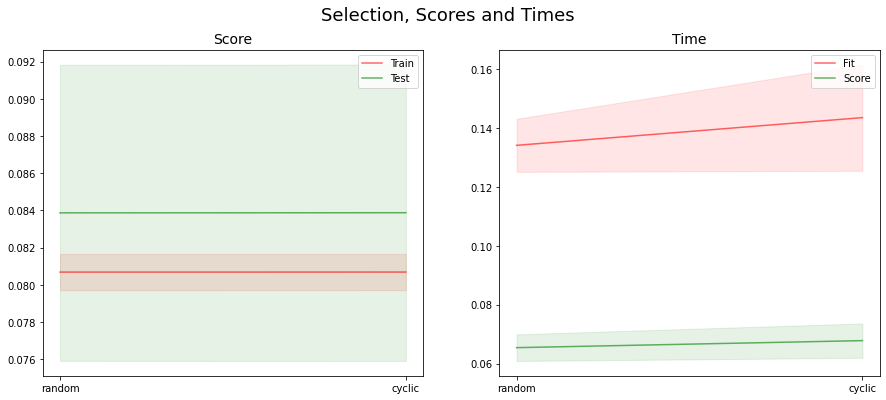

In [53]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.0006000000000000001) & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__positive==False)], 'param_lasso__selection', 'Selection')

Forcing the coefficients to be positive means setting to 0 all the negative one and, as we know, we have features in the data that are supposed to give a negative contribution to the final house price. Thus, we observe that doing so makes the model faster (fewer features with non-zero coefficient) but worse in terms of perfomance.

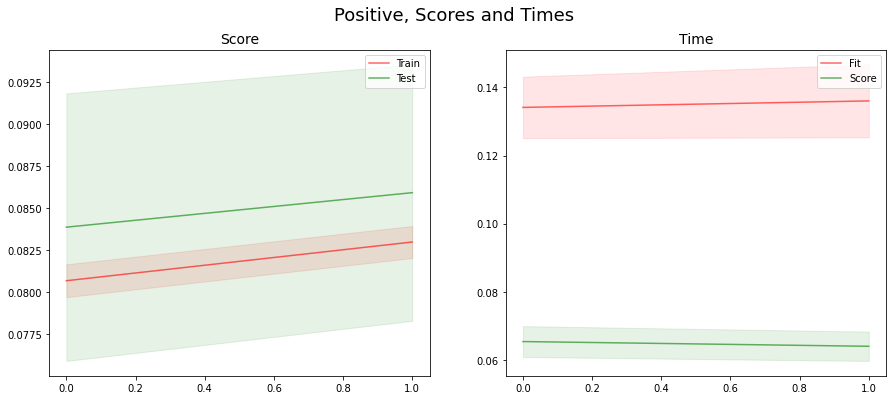

In [54]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.0006000000000000001) & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__positive', 'Positive')

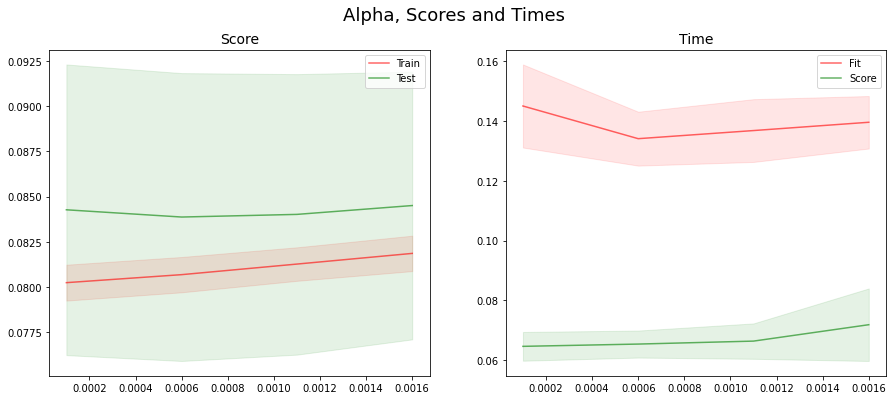

In [55]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'Alpha')

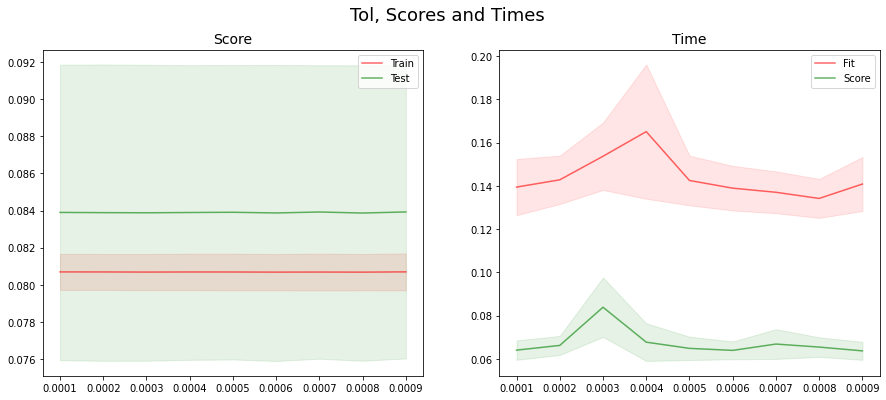

In [56]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__alpha==0.0006000000000000001) & 
                            (res.param_lasso__positive==False)], 'param_lasso__tol', 'Tol')

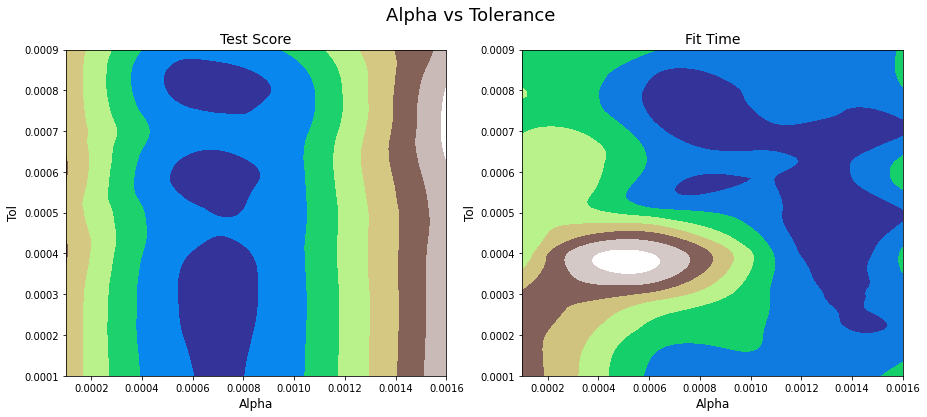

In [57]:
hyp.plot_two_hyperparms(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

We finally see some more interesting patterns, some regularization seems to help but it then stops being helpful. Moreover, at the sweet spot for the hyperparameter `alpha,` we see that playing around with `tol` can improve or worsen the performance of the model. On the other hand, once that `alpha` is away from this spot, this hyperparameter stops being relevant.

We indeed see that adding a small regularizing term leads to a model that not only performs slightly better (to be fair, it is an improvement at the third digit of each metric) but, most importantly, helps the model estimating the coefficients with less uncertainty.

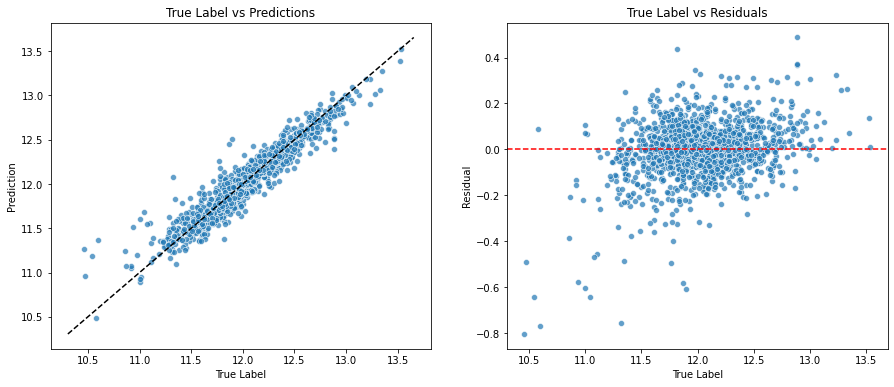

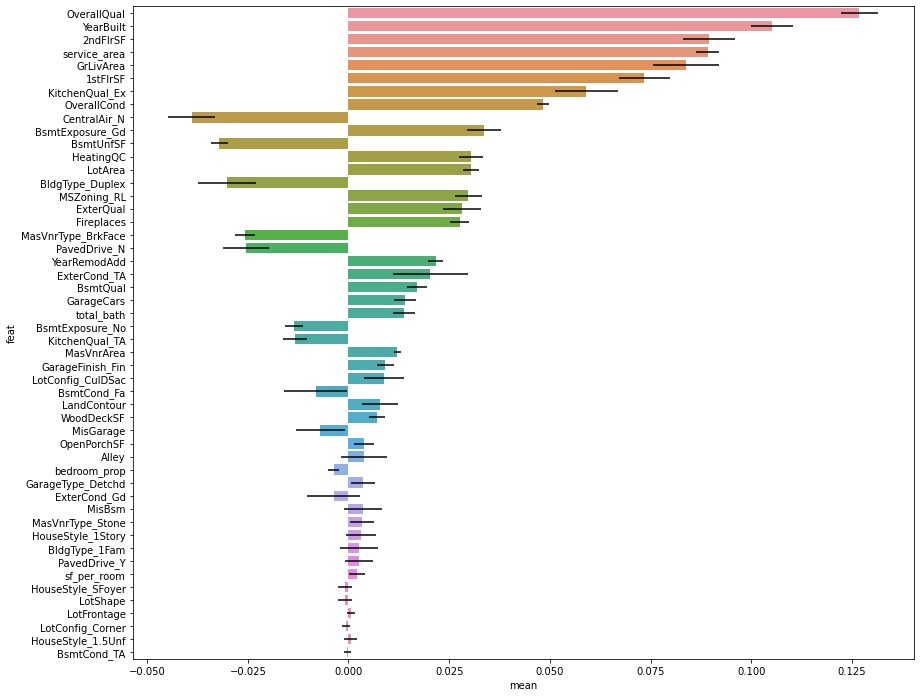

MAE: 		 0.08387
MSE: 		 0.01465
Max Error: 	 0.80364
Expl Variance: 	 0.90823


In [58]:
model = ('lasso', Lasso(alpha=0.0006, tol=0.0008))
params = {'alpha':0.0006, 'tol': 0.0008}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

We observe again the counterintuitive result for the coefficient of `ExterCond_Gd` but we also see how the model is not really sure about it.

If, for fun, we force the coefficients to be positive we get

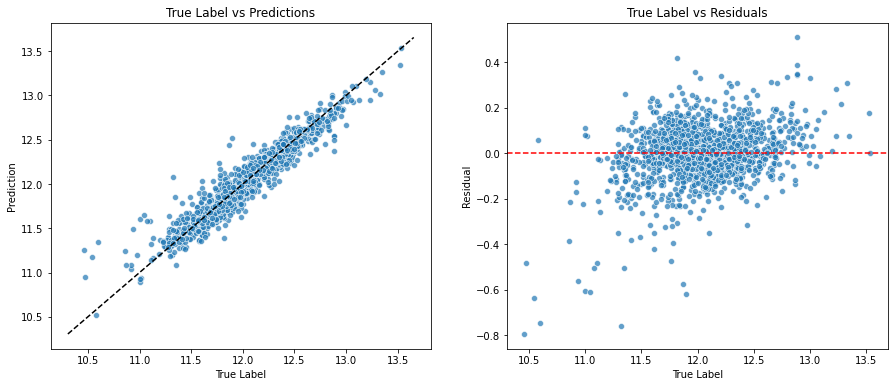

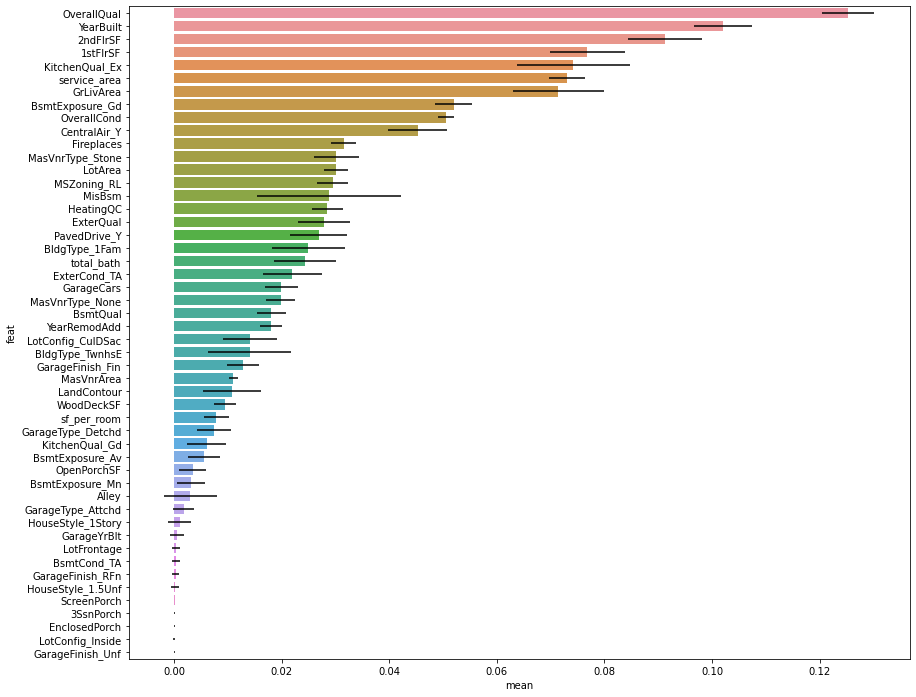

MAE: 		 0.08595
MSE: 		 0.01498
Max Error: 	 0.79482
Expl Variance: 	 0.90621


In [59]:
model = ('lasso', Lasso(alpha=0.0006, tol=0.0008, positive=True))
params = {'alpha':0.0006, 'positive':'True', 'tol': 0.0008}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

It is interesting to notice, for example, that `CentralAir_N` had a negative coefficient and now its coefficient is set to 0 and `CentralAir_Y` pops up with a larger positive coefficient now. The same happens for `PavedDrive_Y` and `PavedDrive_N`.

The very counteintuitive coefficient is the one for `MisBsmt` but, again, we also observe a larger uncertainty.

Bringing the regularization to an extreme value we see how many coefficients are set to 0, compromising the model but showing which one are the extremely relevant features.

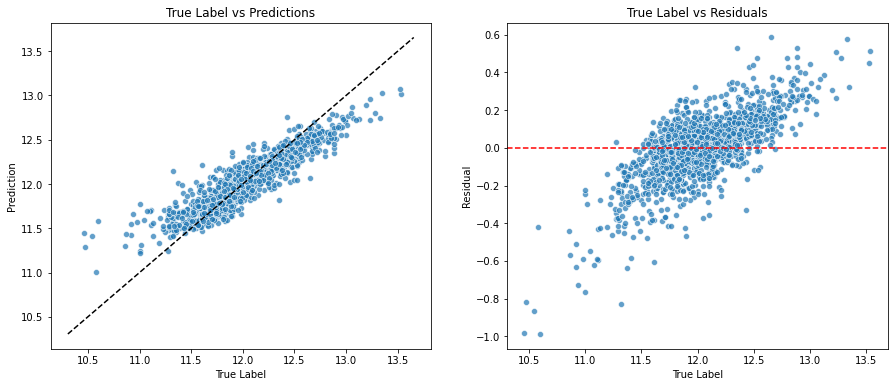

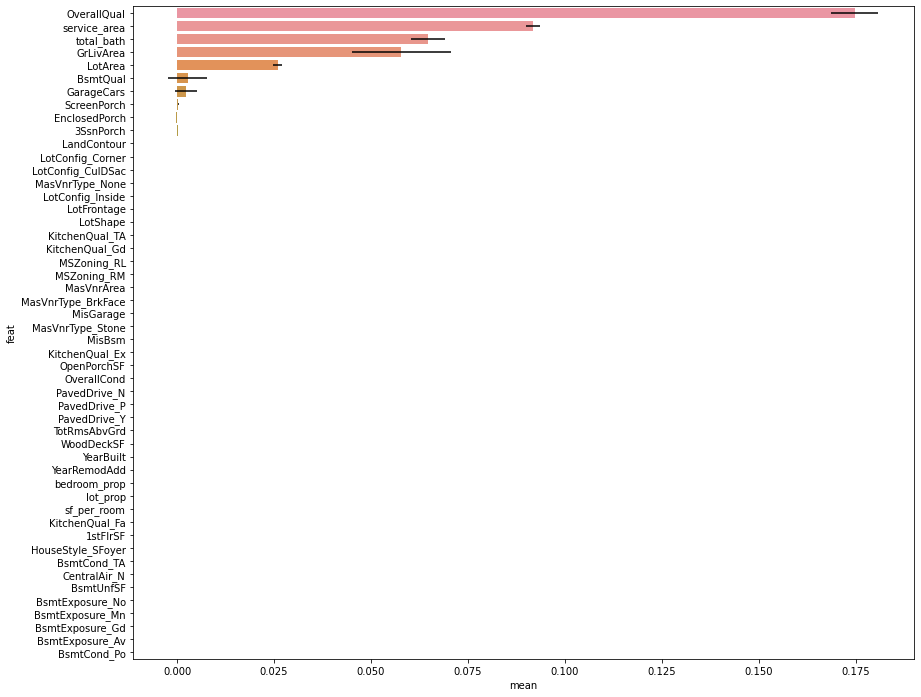

MAE: 		 0.12634
MSE: 		 0.03068
Max Error: 	 0.98818
Expl Variance: 	 0.80783


In [60]:
model = ('lasso', Lasso(alpha=0.05, tol=0.0008))
params = {'alpa':0.05, 'tol': 0.0008}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

# Conclusion

We have seen how, with the synthetic data at hand, adding a regularizing term to our model is not generally helping. However, the regularization is becoming more important when the number of training instances is limited.

In general, the higher is the regularizing parameter, the less the model is learning the data. This can help the predictive power of a model that was previously focusing on the wrong things. The training or prediction times are not affected by the presence or the magnitude of the regularization.

This type of regularization can be used for feature selection but we observe how the number of parameters set to 0 can increase quite dramatically in some cases, making the model way too simple for our scope.

Once again, finding the right value for `alpha` is enough for tuning our model properly but the sklearn implementation allows for several interesting options. For example, we can force the model to have only positive coefficients, very useful for cases where our domain knowledge suggests so. Other options may influence the speed of the model without significantly affecting its accuracy.

The summary of the models' results is the following

In [61]:
df = pd.read_csv(lab_book)
df = df[df.Model=='Lasso'].copy()
df.head()

Date  Model       Parameters                      Target Variables  \
53  24/08/2020  Lasso     {'alpha': 1}      10_feat_10_inf_nonoise       all   
54  24/08/2020  Lasso     {'alpha': 1}        10_feat_10_inf_noise       all   
55  24/08/2020  Lasso  {'alpha': 0.55}       100_feat_65_inf_noise       all   
56  24/08/2020  Lasso     {'alpha': 1}  100_feat_65_inf_noise_rank       all   
57  24/08/2020  Lasso     {'alpha': 1}      10_feat_10_inf_nonoise       all   

    N_instances         MAE            MSE    Max_error  Explained_var  
53       100000    2.525553      10.036854    12.861337       0.999798  
54       100000  159.176429   39913.496361   870.553531       0.553259  
55       100000  359.491618  202607.061051  1937.260280       0.489136  
56       100000    0.932975       1.365112     5.064188      -0.000014  
57          300    2.665997      11.357817     9.619455       0.999766

In [62]:
df[df.Target == 'tar_lin_full']

Date  Model                          Parameters        Target  \
59  24/08/2020  Lasso                        {'alpha': 1}  tar_lin_full   
60  24/08/2020  Lasso                        {'alpha': 1}  tar_lin_full   
61  24/08/2020  Lasso                      {'alpha': 2.5}  tar_lin_full   
62  24/08/2020  Lasso  {'alpha': 0.5, 'positive': 'True'}  tar_lin_full   
63  24/08/2020  Lasso                        {'alpha': 1}  tar_lin_full   

     Variables  N_instances        MAE          MSE   Max_error  Explained_var  
59         all        10000   8.455934   112.862652   48.707896       0.965472  
60         all          100  11.240776   209.355196   42.834291       0.939222  
61         all          100   9.603424   145.065556   29.160528       0.955350  
62         all        10000  40.067305  2595.203200  263.178391       0.214580  
63  unobserved        10000  15.911729   369.401036   57.768441       0.888231

With a target generated linearly with 100 features we observe that

* Moving from 10000 to 100 observations leads to +53% in MAE, +120% in MSE, no relevant change in Max Error, and -7% in explained variance. This is a lower drop with respect to the unregularized experiment of Notebook 3 and to the one with $L_2$ regularization of Notebook 4. 
* With a higher regularization, indeed, the change is +23% in MAE, +40% in MSE, -19% in Max Error, and -0.5% in explained variance.
* Removing 10% of the features leads to +85% in MAE, +224% in MSE, +37% in Max Error, and -8% in explained variance, slightly better than the $L_2$ regularized case


In [63]:
df[df.Target == 'tar_lin_half']

Date  Model      Parameters        Target   Variables  N_instances  \
64  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half       exact        10000   
65  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half       exact          100   
66  24/08/2020  Lasso  {'alpha': 0.6}  tar_lin_half       exact          100   
67  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half         all        10000   
68  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half         all          100   
69  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half    exact-10        10000   
70  24/08/2020  Lasso    {'alpha': 1}  tar_lin_half  unobserved        10000   

          MAE          MSE   Max_error  Explained_var  
64   8.548780   114.234085   42.890484       0.994758  
65  10.014520   159.099784   39.004129       0.993107  
66  11.453846   183.780451   34.151651       0.990780  
67   8.621700   116.858746   43.361313       0.994742  
68  11.597032   220.978246   42.149346       0.988319  
69  32.551318  1449.508230  101.010726       0.932721  
70  34.266054  1611.492845  100.055115       0.924835

With a target generated linearly with 50 features we observe that

* Moving from 10000 to 100 observation leads to +4% in MAE, +10% of MSE, -39% in Max Error, and nearly identical explained variance. This is a staggering result that suggests once again that this type of regularization can help in reducing large errors with a limited amoung of observations.
* If we add 50 extra features, we get a very similar perfomance.
* We again see that the regularization is helpful when the number of observations is reduced, but the drop in performance is more significant.
* On the other hand, it does not help once that some important features are missing.

In [64]:
df[df.Target == 'tar_lin_10']

Date  Model    Parameters      Target   Variables  N_instances  \
71  24/08/2020  Lasso  {'alpha': 1}  tar_lin_10       exact        10000   
72  24/08/2020  Lasso  {'alpha': 1}  tar_lin_10       exact          100   
73  24/08/2020  Lasso  {'alpha': 1}  tar_lin_10         all        10000   
74  24/08/2020  Lasso  {'alpha': 1}  tar_lin_10    exact-10        10000   
75  24/08/2020  Lasso  {'alpha': 1}  tar_lin_10  unobserved        10000   

         MAE       MSE  Max_error  Explained_var  
71  1.244371  2.439552   6.736734       0.957237  
72  1.178199  2.045980   3.522178       0.963335  
73  1.243036  2.419688   6.593501       0.957756  
74  1.594869  3.903591   7.518309       0.932179  
75  1.248171  2.434465   6.089768       0.957519

With a target generated linearly with 10 features we observe a worse performance than the one of the unregularized model because the model is setting too 0 important coefficients. it has to be noticed, however, how the perfomance seems to be uninfluenced by the removal of observations or of features.

The same cannot be said about the prediction of the target variable generated non-linearly, here it is performing better than all the previous models and the drop in perfomance due to the reduced number of observation is much less evident.

In [65]:
df[df.Target == 'tar_nonlin_10']

Date  Model      Parameters         Target Variables  N_instances  \
76  24/08/2020  Lasso    {'alpha': 1}  tar_nonlin_10       all        10000   
77  24/08/2020  Lasso    {'alpha': 1}  tar_nonlin_10       all          100   
78  24/08/2020  Lasso  {'alpha': 2.1}  tar_nonlin_10       all          100   

          MAE         MSE   Max_error  Explained_var  
76  12.741838  302.989341  193.403873       0.979184  
77  20.968840  729.972127   70.044192       0.962317  
78  15.390068  410.911261   60.522497       0.978573